In [33]:
import numpy as np
import pandas as pd
import math
from abc import ABC, abstractmethod
import pymcdm

import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
def convert_to_numbers(data, LV):
    new_data = []
    for row in data:
        temp_row = []
        for val in row:
            if str(val).isnumeric():
                temp_row.append(int(val))
            else:
                temp_row.append(LV[val])
        new_data.append(temp_row)
    return new_data

In [35]:
def fuzzy_ranking(rankings, normalization_axis = None):
    """
    Generate fuzzy ranking matrix based on positional rankings.

    Parameters:
    ------------
    rankings : np.ndarray
        2D array with positional rankings, where each row represents a separate positional ranking of alternatives.

    normalization_axis : int, optional
        Specifies the type of fuzzy ranking representation. 
        If 0, it normalizes the obtained fuzzy rankings regarding values in columns (by distribution of positions for alternatives).
        If 1, it normalizes the obtained fuzzy rankings regarding values in rows (by positions in rankings).
        If None or not specified, it returns the default fuzzy ranking matrix without data normalization.

    Returns:
    ---------
    np.ndarray
        Fuzzy ranking matrix based on the specified normalization_axis. Each element represents the membership degree of alternatives and ranking positions.

    Example:
    ----------
    >>> rankings = np.array([
    ...     [1, 2, 3, 4, 5],
    ...     [2, 1, 5, 3, 4],
    ...     [4, 3, 2, 5, 1],
    ...     [3, 2, 1, 4, 5],
    ... ])
    >>> fuzzy_rank = fuzzy_ranking(rankings, normalization_axis=0)
    >>> print(fuzzy_rank)
    """

    ALT = len(rankings[0])

    columns_labels = [f'A{i+1}' for i in range(ALT)]

    pd_rank = pd.DataFrame(rankings, columns=columns_labels)
    rank_prob = np.zeros((ALT, ALT))  

    tie_positions = np.arange(1.5, ALT+1, 1)

    for row, col in enumerate(pd_rank.columns):
        for pos in range(ALT):
            rank_prob[pos, row] = len(pd_rank[pd_rank[col] == pos+1])

    # tie positions
    for row, col in enumerate(pd_rank.columns):
        for pos in tie_positions:
            count_tie = len(pd_rank[pd_rank[col] == pos])
            if count_tie == 0:
                continue
            # lower position
            rank_prob[int(np.floor(pos))-1, row] += count_tie/2
            # higher position
            rank_prob[int(np.ceil(pos))-1, row] += count_tie/2

    rank_prob = np.round(rank_prob / len(pd_rank), 4)
    rank_prob = pd.DataFrame(rank_prob, columns=columns_labels)

    if normalization_axis is None:
        return rank_prob.to_numpy()
    else:
        M = rank_prob.to_numpy()
        max_values = np.max(M, axis=normalization_axis)
        if normalization_axis == 0:
            FM = np.round(M / max_values, 4)
        else:
            FM = M.copy()
            for i in range(ALT):
                FM[i, :] = np.round(M[i, :] / max_values[i], 4)
        return FM

def fr_compromise(rankings, preferences, m_types):
    distances = []

    for pref, m_type in zip(preferences, m_types):
        distances.append(pymcdm.normalizations.minmax_normalization(pref, m_type))

    fr = fuzzy_ranking(rankings)
    pos = np.arange(1, rankings.shape[1]+1)

    weighted_fr = (fr.T * pos).T

    pref_fr = weighted_fr * ((1-sum(distances)/len(distances))+1)

    comp_w_fr = pymcdm.helpers.rankdata(np.sum(weighted_fr, axis=0))
    comp_p_fr = pymcdm.helpers.rankdata(np.sum(pref_fr, axis=0))

    return comp_w_fr, comp_p_fr


In [36]:
def RANCOM(ranking, verbose=False):
    """Calculate criteria weights based on the given numerical hierarchy. Lower value means higher relevance.

    Parameters
    ----------
        ranking : ndarray
            Numerical values for criteria relevance (lower - more relevant).
        
        f : callable
            Objective function used for filling the Matrix of ranking Comparison (MAC).

        tie_value: float
            Value used to fill MAC when tie is noted

    Returns
    -------
        ndarray
            Criteria weights in range 0-1.
    """
    def f(c1, c2):
        if c1 < c2:
            return 1 + math.log(c2 / c1)
        if c1 == c2:
            return 1
        return 1 / (1 + math.log(c1 / c2))


    def build_mac(ranking):
        co = np.array(list(ranking))

        mac = np.diag(np.ones(co.shape[0]) * 0.5)
        for i in range(mac.shape[0]):
            for j in range(i+1, mac.shape[1]):
                v = f(co[i], co[j])
                mac[i, j] = v
                # mac[j, i] = 1 - v
                mac[j, i] = 1 / v
        return mac

    def get_weights(ranking):
        mac = build_mac(ranking)
        scw = np.sum(mac, axis=1)
        p = scw / np.sum(scw)

        if verbose:
            print('------- MAC ---------')
            print(mac)
            print('------- SCW ---------')
            print(scw)
            print('------- WEIGHTS ---------')
            print(p)

        return p

    return get_weights(ranking)
    

In [37]:
LV_matrix = {
    'EL': 1,
    'VL': 2,
    'L': 3,
    "ML": 4,
    'M': 5,
    "MH": 6,
    "H": 7,
    "VH": 8, 
    "EH": 9 
}
LV_weights = {
    'EL': 9,
    'VL': 8,
    'L': 7,
    "ML": 6,
    'M': 5,
    "MH": 4,
    "H": 3,
    "VH": 2, 
    "EH": 1 
}

# Experts

In [38]:
experts_criteria_s = np.array([
    ["EH", "VH", "H",  "EH", "VH"],
    ["H",  "MH", "M",  "VH", "MH"],
    ["H",  "H",  "MH", "VH", "H"],
    ["M",  "M",  "M",  "H",  "M"],
    ["ML", "M",  "ML", "MH", "M"],
    ["MH", "MH", "MH", "H",  "MH"]
]).T

experts_criteria_w = np.array([
    ["ML", "ML", "VL", "VL", "L"],
    ["MH", "M",  "MH", "ML", "MH"],
    ["VL", "L",  "EL", "VL", "L"],
    ["H",  "MH", "H",  "M",  "H"],
    ["M",  "M",  "M",  "VL", "MH"],
    ["H",  "VH", "H",  "MH", "H"]
]).T

experts_criteria_o = np.array([
    ["H",  "M",  "MH", "MH", "H"],
    ["M",  "ML", "MH", "M",  "MH"],
    ["H",  "MH", "H",  "MH", "H"],
    ["ML", "L",  "M",  "ML", "M"],
    ["EH", "VH", "EH", "EH", "VH"],
    ["MH", "M",  "MH", "M",  "MH"]
]).T

experts_criteria_t = np.array([
    ["MH", "M",  "H",  "MH", "H"],
    ["ML", "M",  "MH", "M",  "MH"],
    ["VL", "ML", "M",  "ML", "M"],
    ["H",  "MH", "H",  "MH", "H"],
    ["EL", "L",  "VL", "VL", "M"],
    ["M",  "M",  "MH", "M",  "MH"]
]).T

experts_e1 = np.array([
    ["L",  "L",  "ML", "L",  "L",  "L",  "ML", "ML"],
    ["EH", "H",  "ML", "M",  "L",  "L",  "MH", "EH"],
    ["M",  "ML", "ML", "M",  "L",  "L",  "EH", "ML"],
    ["EH", "MH", "M",  "MH", "L",  "ML", "M",  "EH"],
    ["ML", "ML", "EH", "ML", "MH", "MH", "ML", "ML"],
    ["EH", "EH", "ML", "EH", "ML", "L",  "MH", "H"],
    ["MH", "H",  "H",  "MH", "MH", "ML", "ML", "MH"],
    ["EH", "H",  "ML", "MH", "ML", "L",  "M",  "EH"],
    ["MH", "H",  "EH", "H",  "MH", "ML", "ML", "MH"],
    ["MH", "H",  "ML", "EH", "L",  "L",  "M",  "MH"],
    ["MH", "MH", "MH", "MH", "EH", "M",  "ML", "H"],
    ["MH", "H",  "ML", "EH", "ML", "ML", "M",  "MH"],
    ["H",  "EH", "ML", "MH", "ML", "L",  "M",  "H"],
    ["H",  "H",  "MH", "MH", "MH", "M",  "M",  "H"],
    ["H",  "EH", "ML", "EH", "L",  "L",  "M",  "MH"],
    ["H",  "H",  "ML", "EH", "L",  "L",  "M",  "MH"],
    ["MH", "MH", "ML", "EH", "ML", "L",  "M",  "H"],
    ["MH", "MH", "ML", "EH", "L",  "L",  "M",  "MH"],
    ["EH", "H",  "MH", "EH", "L",  "L",  "MH", "H"],
    ["MH", "H",  "EH", "MH", "L",  "L",  "EH", "H"],
    ["H",  "H",  "MH", "MH", "M",  "M",  "MH", "MH"],
    ["EH", "H",  "ML", "MH", "L",  "L",  "MH", "EH"],
    ["M",  "M",  "MH", "MH", "ML", "EH", "M",  "M"],
    ["M",  "M",  "EH", "MH", "MH", "MH", "M",  "M"]
]).T

experts_e2 = np.array([
    ["ML", "L",  "ML", "ML", "L",  "L",  "ML", "ML"],
    ["EH", "H",  "M",  "H",  "ML", "ML", "MH", "EH"],
    ["MH", "M",  "ML", "M",  "L",  "ML", "EH", "MH"],
    ["EH", "H",  "MH", "H",  "ML", "ML", "MH", "EH"],
    ["M",  "ML", "EH", "ML", "H",  "MH", "ML", "M"],
    ["EH", "EH", "M",  "EH", "ML", "L",  "ML", "H"],
    ["MH", "H",  "MH", "H",  "H",  "ML", "ML", "H"],
    ["EH", "H",  "M",  "H",  "ML", "L",  "M",  "EH"],
    ["H",  "H",  "EH", "H",  "MH", "ML", "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "L",  "ML", "H"],
    ["MH", "MH", "H",  "H",  "EH", "M",  "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "ML", "ML", "H"],
    ["H",  "EH", "M",  "H",  "ML", "L",  "ML", "H"],
    ["H",  "H",  "MH", "H",  "MH", "M",  "M",  "H"],
    ["H",  "EH", "M",  "EH", "ML", "L",  "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "L",  "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "L",  "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "ML", "L",  "H"],
    ["EH", "H",  "M",  "EH", "ML", "ML", "L",  "H"],
    ["H",  "H",  "M",  "H",  "ML", "EH", "L",  "H"],
    ["H",  "H",  "MH", "H",  "MH", "M",  "M",  "H"],
    ["EH", "H",  "M",  "H",  "ML", "M",  "L",  "EH"],
    ["M",  "M",  "MH", "H",  "M",  "ML", "EH", "M"],
    ["M",  "M",  "EH", "H",  "MH", "ML", "EH", "M"]
]).T

experts_e3 = np.array([
    ["M",  "L",  "ML", "M",  "L",  "L",  "ML", "ML"],
    ["EH", "H",  "M",  "H",  "M",  "ML", "MH", "EH"],
    ["H",  "M",  "ML", "M",  "L",  "ML", "EH", "MH"],
    ["EH", "H",  "MH", "H",  "M",  "ML", "MH", "EH"],
    ["M",  "ML", "EH", "M",  "H",  "MH", "ML", "M"],
    ["EH", "EH", "MH", "EH", "M",  "ML", "M",  "H"],
    ["H",  "H",  "MH", "H",  "H",  "ML", "M",  "H"],
    ["EH", "H",  "MH", "H",  "M",  "L",  "M",  "EH"],
    ["H",  "H",  "EH", "H",  "MH", "ML", "ML", "H"],
    ["H",  "H",  "M",  "EH", "ML", "L",  "M",  "H"],
    ["H",  "MH", "H",  "H",  "EH", "M",  "M",  "H"],
    ["H",  "H",  "MH", "EH", "M",  "ML", "M",  "H"],
    ["H",  "EH", "M",  "H",  "ML", "L",  "ML", "H"],
    ["H",  "H",  "MH", "H",  "MH", "M",  "M",  "H"],
    ["H",  "EH", "MH", "EH", "M",  "L",  "M",  "H"],
    ["H",  "H",  "MH", "EH", "M",  "L",  "M",  "H"],
    ["H",  "H",  "MH", "EH", "M",  "L",  "M",  "H"],
    ["H",  "H",  "MH", "EH", "M",  "L",  "M",  "H"],
    ["EH", "H",  "M",  "EH", "M",  "L",  "M",  "H"],
    ["H",  "H",  "M",  "H",  "M",  "ML", "EH", "H"],
    ["H",  "H",  "MH", "H",  "MH", "M",  "M",  "H"],
    ["EH", "H",  "M",  "H",  "M",  "L",  "M",  "EH"],
    ["M",  "M",  "MH", "H",  "MH", "EH", "M",  "M"],
    ["M",  "M",  "EH", "H",  "EH", "EH", "M",  "M"]
]).T

experts_e4 = np.array([
    ["ML", "H",  "L",  "VH", "L",  "ML", "ML", "H"],
    ["VH", "MH", "ML", "H",  "M",  "L",  "M",  "VH"],
    ["M",  "ML", "L",  "H",  "L",  "M",  "H",  "M"],
    ["H",  "H",  "M",  "VH", "VL", "L",  "M",  "EH"],
    ["M",  "VH", "EH", "MH", "H",  "ML", "L",  "M"],
    ["MH", "H",  "ML", "VH", "M",  "VL", "ML", "EH"],
    ["MH", "VH", "M",  "EH", "ML", "L",  "VL", "H"],
    ["VH", "M",  "VL", "M",  "L",  "VL", "MH", "VH"],
    ["MH", "MH", "VH", "H",  "MH", "VL", "L",  "H"],
    ["M",  "M",  "L",  "VH", "L",  "L",  "VL", "MH"],
    ["L",  "M",  "L",  "M",  "VH", "VL", "ML", "M"],
    ["M",  "VH", "M",  "EH", "L",  "L",  "VL", "EH"],
    ["H",  "EH", "MH", "H",  "L",  "M",  "L",  "VH"],
    ["MH", "H",  "ML", "H",  "VH", "L",  "ML", "M"],
    ["MH", "VH", "L",  "EH", "L",  "ML", "VL", "H"],
    ["M",  "VH", "L",  "VH", "VL", "L",  "L",  "H"],
    ["H",  "MH", "M",  "H",  "MH", "MH", "L",  "EH"],
    ["VL", "M",  "L",  "VH", "L",  "L",  "VL", "M"],
    ["M",  "ML", "ML", "M",  "M",  "M",  "L",  "VH"],
    ["ML", "ML", "L",  "MH", "ML", "ML", "VH", "H"],
    ["L",  "M",  "H",  "M",  "MH", "M",  "L",  "L"],
    ["VH", "ML", "VL", "M",  "M",  "VL", "ML", "VH"],
    ["L",  "L",  "H",  "L",  "ML", "VH", "ML", "M"],
    ["VL", "M",  "VH", "ML", "MH", "L",  "ML", "VH"]
]).T

experts_e5 = np.array([
    ["MH", "M",  "L",  "M",  "ML", "L",  "L",  "M"],
    ["VH", "M",  "ML", "H",  "ML", "VL", "VL", "H"],
    ["H",  "L",  "L",  "M",  "ML", "VL", "H",  "M"],
    ["VH", "ML", "M",  "H",  "MH", "L",  "M",  "VH"],
    ["M",  "L",  "MH", "M",  "MH", "M",  "VL", "M"],
    ["MH", "MH", "MH", "H",  "ML", "VL", "ML", "MH"],
    ["H",  "ML", "H",  "M",  "M",  "M",  "L",  "H"],
    ["VH", "M",  "L",  "M",  "L",  "ML", "M",  "H"],
    ["M",  "VL", "VH", "L",  "VL", "M",  "VL", "M"],
    ["ML", "L",  "MH", "H",  "VL", "VL", "VL", "M"],
    ["VH", "ML", "L",  "M",  "VH", "ML", "VL", "H"],
    ["MH", "M",  "ML", "H",  "L",  "M",  "L",  "H"],
    ["H",  "VH", "M",  "M",  "L",  "ML", "ML", "H"],
    ["M",  "VH", "ML", "MH", "M",  "L",  "L",  "M"],
    ["M",  "H",  "ML", "VH", "VL", "M",  "ML", "VH"],
    ["MH", "ML", "ML", "VH", "VL", "ML", "VL", "H"],
    ["MH", "M",  "M",  "VH", "M",  "M",  "ML", "MH"],
    ["VL", "ML", "M",  "MH", "L",  "VL", "VL", "M"],
    ["H",  "M",  "L",  "M",  "ML", "ML", "M",  "H"],
    ["MH", "L",  "ML", "VL", "ML", "L",  "VH", "M"],
    ["M",  "M",  "M",  "VL", "ML", "M",  "VL", "MH"],
    ["VH", "VL", "M",  "M",  "VL", "L",  "ML", "VH"],
    ["L",  "L",  "M",  "L",  "L",  "VH", "ML", "M"],
    ["VL", "L",  "VH", "ML", "L",  "M",  "ML", "MH"]
]).T

experts_matrix = np.array([experts_e1, experts_e2, experts_e3, experts_e4, experts_e5])


# ChatGPT 5.1

Experts individual

In [39]:
gpt_criteria_s = np.array([
    ["H",  "VH", "VH", "H",  "VH"],
    ["VH", "H",  "H",  "VH", "H"],
    ["MH", "VH", "VH", "MH", "VH"],
    ["EH", "MH", "EH", "EH", "H"],
    ["MH", "M",  "MH", "M",  "MH"],
    ["VH", "MH", "H",  "MH", "H"]
]).T

gpt_criteria_w = np.array([
    ["MH", "H",  "MH", "MH", "MH"],
    ["VH", "VH", "VH", "VH", "VH"],
    ["H",  "H",  "H",  "H",  "H"],
    ["EH", "EH", "EH", "EH", "EH"],
    ["VH", "MH", "H",  "H",  "H"],
    ["EH", "VH", "VH", "VH", "VH"]
]).T

gpt_criteria_o = np.array([
    ["MH", "MH", "MH", "MH", "H"],
    ["VH", "H",  "VH", "EH", "VH"],
    ["EH", "VH", "EH", "VH", "EH"],
    ["MH", "M",  "M",  "M",  "MH"],
    ["H",  "VH", "VH", "H",  "H"],
    ["VH", "H",  "H",  "VH", "VH"]
]).T

gpt_criteria_t = np.array([
    ["VH", "H",  "VH", "H",  "H"],
    ["EH", "VH", "EH", "VH", "VH"],
    ["MH", "M",  "H",  "H",  "MH"],
    ["EH", "VH", "VH", "EH", "VH"],
    ["VH", "H",  "H",  "VH", "H"],
    ["VH", "VH", "VH", "H",  "VH"]
]).T

gpt_e1 = np.array([
    ["L","MH","ML","M","ML","M","M","MH"],
    ["EH","MH","M","ML","ML","L","ML","VH"],
    ["ML","MH","ML","M","L","ML","EH","MH"],
    ["VH","H","M","MH","ML","ML","M","EH"],
    ["ML","M","EH","MH","M","MH","L","H"],
    ["H","VH","M","VH","ML","L","ML","H"],
    ["ML","M","H","MH","MH","ML","L","M"],
    ["H","ML","M","MH","L","ML","ML","VH"],
    ["L","ML","VH","MH","ML","ML","EL","H"],
    ["ML","M","MH","EH","ML","L","EL","M"],
    ["L","ML","ML","M","EH","ML","EL","H"],
    ["ML","ML","MH","MH","M","ML","L","M"],
    ["L","EH","M","H","ML","ML","EL","MH"],
    ["M","VH","MH","MH","H","ML","EL","VH"],
    ["ML","VH","H","EH","M","ML","EL","H"],
    ["ML","H","M","EH","L","ML","EL","H"],
    ["ML","MH","MH","MH","M","ML","ML","H"],
    ["ML","H","M","VH","ML","ML","EL","MH"],
    ["VH","ML","ML","M","L","L","L","H"],
    ["ML","L","L","ML","EL","EL","EH","MH"],
    ["M","MH","MH","M","M","ML","EL","MH"],
    ["EH","M","ML","ML","ML","L","ML","VH"],
    ["ML","ML","MH","ML","ML","EH","EL","H"],
    ["L","ML","EH","MH","M","ML","EL","H"]
]).T

gpt_e2 = np.array([
    ["ML","EH","L","H","M","MH","L","MH","ML","L","ML","M","MH","M","ML","M","ML","ML","H","L","ML","EH","ML","M"],
    ["M","H","ML","MH","MH","H","ML","M","M","ML","ML","ML","H","H","VH","M","MH","H","M","L","M","MH","M","MH"],
    ["M","ML","M","M","EH","ML","ML","ML","EH","ML","M","ML","ML","MH","H","ML","ML","MH","ML","ML","M","M","H","EH"],
    ["ML","M","M","EH","ML","MH","MH","MH","M","EH","M","MH","M","MH","EH","VH","MH","H","ML","ML","ML","M","ML","M"],
    ["ML","ML","ML","M","H","M","MH","ML","MH","M","EH","ML","ML","VH","MH","M","MH","MH","ML","ML","ML","ML","ML","MH"],
    ["ML","ML","L","ML","M","ML","L","ML","MH","ML","ML","ML","ML","MH","H","ML","ML","MH","ML","ML","H","ML","EH","MH"],
    ["L","ML","EH","L","L","ML","ML","MH","L","M","L","ML","L","L","ML","ML","ML","L","M","EH","ML","ML","ML","L"],
    ["M","VH","M","H","MH","VH","MH","H","MH","MH","H","H","H","H","MH","M","H","MH","MH","MH","MH","VH","H","MH"]
])

gpt_e3 = np.array([
    ["MH","H","M","ML","ML","M","H","H"],
    ["EH","MH","M","ML","ML","L","ML","H"],
    ["ML","L","ML","M","L","L","EH","MH"],
    ["H","MH","H","MH","M","M","ML","EH"],
    ["ML","M","EH","M","MH","MH","L","H"],
    ["H","EH","MH","MH","M","ML","ML","H"],
    ["ML","MH","H","M","MH","ML","L","MH"],
    ["H","MH","M","ML","L","ML","L","VH"],
    ["L","ML","EH","M","ML","ML","EL","MH"],
    ["ML","ML","M","EH","L","L","EL","MH"],
    ["ML","M","ML","M","EH","L","EL","H"],
    ["M","ML","M","MH","L","EH","L","H"],
    ["ML","EH","MH","M","ML","ML","L","MH"],
    ["M","MH","MH","M","EH","ML","L","H"],
    ["ML","MH","M","EH","ML","ML","EL","H"],
    ["ML","ML","ML","MH","M","M","L","H"],
    ["M","MH","MH","MH","ML","ML","L","H"],
    ["ML","M","M","EH","ML","ML","EL","H"],
    ["H","MH","ML","ML","L","L","ML","EH"],
    ["ML","L","L","ML","EL","EL","EH","MH"],
    ["ML","MH","MH","M","ML","ML","L","H"],
    ["EH","MH","M","L","ML","L","ML","VH"],
    ["L","ML","M","L","ML","EH","EL","MH"],
    ["ML","ML","EH","ML","ML","M","EL","H"]
]).T

gpt_e4 = np.array([
    ["M","MH","MH","M","ML","M","H","M"],
    ["EH","H","M","ML","M","L","ML","VH"],
    ["ML","M","MH","M","L","L","EH","M"],
    ["H","MH","M","MH","ML","M","M","EH"],
    ["M","H","EH","MH","MH","MH","ML","H"],
    ["MH","EH","M","VH","ML","ML","L","H"],
    ["ML","M","MH","M","H","ML","L","MH"],
    ["EH","MH","ML","M","L","L","ML","H"],
    ["L","M","EH","MH","M","ML","L","MH"],
    ["ML","MH","M","EH","L","L","L","MH"],
    ["M","ML","M","ML","EH","ML","L","H"],
    ["ML","M","ML","MH","L","MH","L","M"],
    ["MH","VH","M","ML","M","ML","ML","H"],
    ["M","H","MH","MH","H","ML","L","EH"],
    ["ML","EH","MH","VH","M","ML","L","H"],
    ["ML","MH","M","EH","ML","ML","ML","H"],
    ["M","MH","MH","H","M","MH","ML","VH"],
    ["ML","MH","MH","VH","ML","ML","L","H"],
    ["EH","MH","ML","M","ML","L","MH","H"],
    ["ML","M","L","ML","L","L","EH","MH"],
    ["M","MH","ML","M","ML","ML","ML","H"],
    ["EH","MH","M","ML","M","ML","ML","EH"],
    ["ML","ML","M","ML","ML","EH","L","H"],
    ["L","M","EH","ML","MH","M","L","MH"]
]).T

gpt_e5 = np.array([
    ["ML","H","MH","M","ML","H","ML","M"],
    ["EH","MH","M","ML","ML","L","L","H"],
    ["ML","M","L","ML","L","L","H","MH"],
    ["MH","MH","M","M","ML","ML","L","H"],
    ["M","ML","VH","ML","H","M","L","MH"],
    ["MH","EH","M","H","ML","M","L","MH"],
    ["L","ML","M","ML","ML","M","L","MH"],
    ["MH","M","L","ML","L","L","ML","VH"],
    ["L","ML","EH","M","ML","M","L","MH"],
    ["ML","M","L","EH","L","L","ML","MH"],
    ["L","ML","ML","ML","EH","L","L","H"],
    ["L","ML","M","ML","L","M","L","H"],
    ["MH","VH","ML","ML","ML","ML","L","H"],
    ["M","H","M","ML","H","ML","L","VH"],
    ["ML","H","M","EH","ML","ML","L","H"],
    ["ML","ML","L","H","ML","ML","L","MH"],
    ["ML","ML","ML","H","ML","ML","L","MH"],
    ["ML","H","ML","H","ML","ML","L","MH"],
    ["MH","M","L","ML","L","L","ML","VH"],
    ["ML","ML","L","L","L","L","EH","MH"],
    ["M","ML","ML","L","ML","ML","L","MH"],
    ["EH","MH","M","ML","L","L","L","VH"],
    ["ML","ML","M","ML","ML","EH","L","MH"],
    ["L","ML","EH","ML","ML","M","L","H"]
]).T

gpt_matrices = np.array([gpt_e1, gpt_e2, gpt_e3, gpt_e4, gpt_e5])

Experts collectively

In [40]:
gpt_collectively_criteria_s = np.array([
    ["VH","H","VH","MH","H"],
    ["EH","H","H","VH","EH"],
    ["H","MH","H","MH","MH"],
    ["EH","VH","H","VH","H"],
    ["MH","M","MH","MH","H"],
    ["H","H","VH","H","MH"]
]).T

gpt_collectively_criteria_w = np.array([
    ["H","MH","H","MH","MH"],
    ["EH","H","VH","EH","H"],
    ["VH","H","MH","H","MH"],
    ["EH","EH","VH","EH","EH"],
    ["H","MH","H","MH","H"],
    ["VH","H","VH","VH","VH"]
]).T

gpt_collectively_criteria_o = np.array([
    ["MH","M","MH","MH","M"],
    ["H","VH","H","H","VH"],
    ["VH","H","VH","H","H"],
    ["M","ML","M","ML","ML"],
    ["H","H","H","H","MH"],
    ["MH","MH","H","MH","H"]
]).T

gpt_collectively_criteria_t = np.array([
    ["EH","H","VH","EH","H"],
    ["EH","VH","H","EH","VH"],
    ["MH","H","MH","MH","H"],
    ["EH","H","VH","EH","H"],
    ["VH","H","VH","VH","VH"],
    ["VH","MH","H","VH","H"]
]).T

gpt_collectively_e1 = np.array([
    ["H","EH","M","MH","ML","MH","M","H","ML","M","M","M","ML","H","MH","L","MH","M","EH","H","M","EH","M","ML"],
    ["MH","MH","MH","H","MH","H","ML","MH","MH","MH","ML","ML","H","H","EH","ML","H","H","MH","ML","ML","MH","MH","MH"],
    ["M","MH","M","MH","EH","MH","ML","ML","H","ML","M","M","ML","H","MH","L","MH","MH","ML","ML","MH","ML","H","EH"],
    ["MH","MH","MH","H","ML","H","L","MH","ML","EH","ML","ML","MH","H","EH","ML","H","H","MH","ML","ML","MH","ML","ML"],
    ["M","MH","ML","ML","MH","ML","MH","ML","MH","ML","H","L","MH","H","ML","L","MH","ML","ML","ML","ML","ML","MH","ML"],
    ["ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","M","MH","MH","L","ML","ML","ML","ML","MH","ML","EH","MH"],
    ["ML","H","H","M","ML","M","MH","H","ML","MH","ML","ML","M","ML","ML","ML","ML","ML","H","EH","ML","H","ML","ML"],
    ["MH","EH","M","MH","MH","MH","M","H","MH","M","MH","M","MH","H","MH","M","H","MH","EH","H","M","EH","M","MH"]
])

gpt_collectively_e2 = np.array([
    ["H","EH","M","MH","ML","MH","M","H","ML","M","M","M","ML","H","MH","L","MH","M","EH","H","M","EH","M","ML"],
    ["MH","MH","MH","H","MH","H","ML","MH","MH","MH","ML","ML","H","H","EH","ML","H","H","MH","ML","ML","MH","MH","MH"],
    ["M","MH","M","MH","EH","MH","ML","ML","H","ML","M","M","ML","H","MH","L","MH","MH","ML","ML","MH","ML","H","EH"],
    ["MH","MH","MH","H","ML","H","L","MH","ML","EH","ML","ML","MH","H","EH","ML","H","H","MH","ML","ML","MH","ML","ML"],
    ["M","MH","ML","ML","MH","ML","MH","ML","MH","ML","H","L","MH","H","ML","L","MH","ML","ML","ML","ML","ML","MH","ML"],
    ["ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","M","MH","MH","L","ML","ML","ML","ML","MH","ML","EH","MH"],
    ["ML","H","H","M","ML","M","MH","H","ML","MH","ML","ML","M","ML","ML","ML","ML","ML","H","EH","ML","H","ML","ML"],
    ["MH","EH","M","MH","MH","MH","M","H","MH","M","MH","M","MH","H","MH","M","H","MH","EH","H","M","EH","M","MH"]
])

gpt_collectively_e3 = np.array([
    ["MH","H","M","MH","ML","MH","M","MH","ML","M","M","M","ML","H","MH","L","MH","M","EH","H","M","EH","M","ML"],
    ["H","MH","MH","H","MH","H","ML","MH","MH","MH","ML","ML","H","H","EH","ML","H","H","MH","ML","ML","MH","MH","MH"],
    ["MH","MH","MH","MH","EH","H","ML","ML","H","ML","M","M","ML","H","MH","L","MH","MH","ML","ML","MH","ML","H","EH"],
    ["H","MH","MH","H","ML","H","L","MH","ML","EH","ML","ML","MH","H","EH","ML","H","H","MH","ML","ML","MH","ML","ML"],
    ["M","MH","ML","ML","H","ML","MH","ML","MH","ML","H","L","MH","H","ML","L","MH","ML","ML","ML","ML","ML","MH","ML"],
    ["ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","M","MH","MH","L","ML","ML","ML","ML","MH","ML","EH","MH"],
    ["M","H","H","M","ML","M","MH","H","ML","MH","ML","ML","M","ML","ML","ML","ML","ML","H","EH","ML","H","ML","ML"],
    ["MH","VH","M","MH","MH","MH","M","H","MH","M","MH","M","MH","H","MH","M","H","MH","EH","H","M","EH","M","MH"]
])

gpt_collectively_e4 = np.array([
    ["MH","VH","M","MH","ML","MH","M","EH","ML","M","M","M","ML","H","MH","L","MH","M","EH","H","M","EH","M","ML"],
    ["MH","H","MH","H","MH","H","ML","MH","MH","MH","ML","ML","H","H","EH","ML","H","H","MH","ML","ML","MH","MH","MH"],
    ["MH","MH","MH","MH","H","MH","ML","ML","H","ML","M","M","ML","H","MH","L","MH","MH","ML","ML","MH","ML","H","EH"],
    ["H","MH","MH","H","ML","H","L","MH","ML","EH","ML","ML","MH","H","EH","ML","H","H","MH","ML","ML","MH","ML","ML"],
    ["M","MH","ML","ML","H","ML","MH","ML","MH","ML","H","L","MH","H","ML","L","MH","ML","ML","ML","ML","ML","MH","ML"],
    ["ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","M","MH","MH","L","ML","ML","ML","ML","MH","ML","EH","MH"],
    ["ML","H","H","M","ML","M","MH","H","ML","MH","ML","ML","M","ML","ML","ML","ML","ML","H","EH","ML","H","ML","ML"],
    ["MH","EH","M","MH","MH","MH","M","H","MH","M","MH","M","MH","H","MH","M","H","MH","EH","H","M","EH","M","MH"]
])

gpt_collectively_e5 = np.array([
    ["MH","EH","M","MH","ML","MH","M","H","ML","M","M","M","ML","H","MH","L","MH","M","EH","H","M","EH","M","ML"],
    ["MH","H","MH","H","MH","H","ML","MH","MH","MH","ML","ML","H","VH","EH","ML","H","H","MH","ML","ML","MH","MH","MH"],
    ["M","H","M","MH","H","MH","ML","ML","H","ML","M","M","ML","H","MH","L","MH","MH","ML","ML","MH","ML","H","H"],
    ["H","MH","MH","H","ML","H","L","MH","ML","EH","ML","ML","MH","H","EH","ML","H","H","MH","ML","ML","MH","ML","ML"],
    ["M","MH","ML","ML","H","ML","MH","ML","MH","ML","H","L","MH","H","ML","L","MH","ML","ML","ML","ML","ML","MH","ML"],
    ["ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","M","MH","H","L","ML","ML","ML","ML","MH","ML","EH","MH"],
    ["ML","H","H","M","ML","M","MH","H","ML","MH","ML","ML","M","ML","ML","ML","ML","ML","H","EH","ML","H","ML","ML"],
    ["MH","H","M","MH","MH","MH","M","H","MH","M","MH","M","MH","H","MH","M","H","MH","EH","H","M","EH","M","MH"]
])

gpt_collectively_matrices = np.array([gpt_collectively_e1, gpt_collectively_e2, gpt_collectively_e3, gpt_collectively_e4, gpt_collectively_e5])

# Claude Sonnet 4.5

Experts individually

In [41]:
sonnet_criteria_s = np.array([
    ["VH","VH","VH","VH","VH"],
    ["H","H","H","H","H"],
    ["MH","H","MH","H","H"],
    ["H","MH","MH","VH","VH"],
    ["M","M","MH","MH","MH"],
    ["H","H","VH","VH","VH"]
]).T

sonnet_criteria_w = np.array([
    ["H","H","H","H","H"],
    ["VH","VH","VH","VH","VH"],
    ["H","VH","H","H","H"],
    ["VH","H","EH","EH","EH"],
    ["H","H","MH","MH","H"],
    ["VH","VH","EH","VH","VH"]
]).T

sonnet_criteria_o = np.array([
    ["MH","H","H","H","MH"],
    ["VH","VH","VH","VH","H"],
    ["H","H","EH","VH","EH"],
    ["H","H","VH","H","H"],
    ["EH","VH","VH","EH","VH"],
    ["VH","VH","EH","VH","VH"]
]).T

sonnet_criteria_t = np.array([
    ["H","H","H","H","MH"],
    ["VH","VH","VH","VH","H"],
    ["MH","MH","H","H","H"],
    ["H","H","VH","EH","EH"],
    ["VH","VH","EH","VH","VH"],
    ["H","H","H","VH","VH"]
]).T

sonnet_e1 = np.array([
    [5,9,3,8,5,7,5,8,5,4,6,5,7,7,6,7,5,3,8,5,5,9,5,5],
    [5,7,5,7,7,8,6,6,7,7,6,7,9,8,9,8,6,7,7,5,6,6,7,7],
    [6,5,5,6,9,6,7,3,9,6,7,7,6,7,5,6,7,8,6,5,7,5,9,9],
    [3,5,5,7,5,9,8,5,6,9,6,8,7,7,8,9,8,7,8,6,5,6,5,6],
    [4,5,3,6,7,6,8,4,7,5,9,4,5,8,6,5,7,5,5,4,6,5,6,8],
    [8,5,7,5,7,5,8,4,6,5,6,7,5,6,5,5,7,6,5,6,8,5,9,7],
    [5,6,9,6,3,5,8,8,4,6,5,8,5,5,5,6,6,4,6,9,5,7,6,3],
    [5,8,5,8,6,7,7,7,6,7,8,6,8,8,7,8,7,6,9,7,6,9,7,7]
])

sonnet_e2 = np.array([
    [3, 9, 4, 8, 5, 7, 5, 7, 4, 5, 6, 6, 7, 7, 6, 6, 6, 5, 8, 6, 5, 9, 5, 5],
    [5, 6, 4, 6, 7, 8, 6, 5, 6, 7, 5, 5, 9, 8, 9, 8, 7, 7, 6, 4, 6, 6, 6, 7],
    [6, 4, 5, 5, 9, 6, 7, 4, 9, 6, 7, 7, 6, 7, 6, 6, 7, 8, 6, 5, 8, 5, 9, 9],
    [5, 5, 6, 7, 5, 9, 8, 6, 5, 9, 6, 7, 7, 6, 8, 9, 8, 7, 7, 7, 5, 6, 6, 6],
    [4, 5, 4, 6, 8, 7, 7, 4, 7, 5, 9, 5, 6, 8, 5, 5, 7, 6, 5, 5, 7, 5, 7, 8],
    [8, 4, 7, 5, 7, 7, 6, 4, 6, 7, 6, 6, 6, 6, 6, 5, 8, 7, 5, 6, 7, 4, 9, 7],
    [6, 6, 8, 6, 4, 7, 7, 8, 4, 6, 5, 7, 5, 5, 5, 6, 7, 5, 6, 9, 5, 6, 5, 4],
    [5, 8, 5, 8, 6, 7, 7, 7, 5, 6, 8, 6, 8, 9, 7, 7, 8, 6, 8, 7, 6, 9, 6, 6]
])

sonnet_e3 = np.array([
    [5, 9, 4, 8, 6, 7, 6, 8, 5, 6, 6, 7, 7, 7, 7, 7, 6, 5, 8, 7, 6, 9, 6, 5],
    [6, 7, 5, 7, 7, 8, 5, 6, 6, 7, 6, 6, 9, 9, 9, 8, 7, 8, 6, 5, 7, 6, 7, 7],
    [7, 5, 6, 6, 9, 6, 7, 4, 9, 7, 7, 7, 6, 7, 6, 6, 7, 8, 7, 5, 8, 5, 8, 9],
    [6, 6, 6, 8, 5, 9, 8, 6, 5, 9, 6, 8, 7, 8, 9, 9, 9, 7, 8, 6, 6, 7, 7, 6],
    [5, 5, 4, 6, 7, 6, 8, 5, 7, 5, 9, 5, 6, 8, 6, 6, 7, 6, 6, 4, 7, 6, 6, 7],
    [8, 4, 7, 5, 7, 7, 7, 5, 6, 6, 6, 6, 6, 7, 7, 5, 7, 7, 5, 6, 8, 5, 9, 8],
    [6, 6, 8, 7, 4, 7, 6, 7, 4, 7, 5, 6, 6, 6, 6, 6, 6, 6, 7, 9, 5, 6, 6, 4],
    [7, 8, 6, 9, 6, 7, 7, 7, 6, 7, 8, 7, 8, 9, 8, 8, 8, 7, 9, 7, 7, 9, 7, 6]
])

sonnet_e4 = np.array([
    [5, 9, 5, 8, 6, 8, 4, 8, 4, 3, 6, 6, 7, 6, 7, 6, 6, 5, 8, 6, 5, 9, 5, 6],
    [6, 7, 4, 7, 8, 9, 6, 6, 8, 8, 7, 7, 9, 8, 9, 8, 7, 8, 8, 6, 7, 7, 8, 8],
    [7, 5, 7, 7, 9, 7, 8, 5, 9, 7, 8, 8, 7, 8, 7, 7, 8, 8, 7, 7, 8, 7, 9, 9],
    [6, 6, 6, 8, 7, 9, 8, 6, 7, 9, 7, 8, 8, 7, 9, 9, 8, 8, 8, 7, 6, 7, 7, 8],
    [5, 5, 5, 6, 8, 7, 8, 3, 8, 4, 9, 5, 6, 8, 6, 5, 7, 6, 5, 5, 7, 6, 7, 7],
    [8, 5, 7, 6, 8, 6, 7, 4, 7, 5, 7, 7, 7, 7, 7, 6, 8, 5, 6, 7, 8, 7, 9, 8],
    [7, 7, 9, 7, 4, 6, 6, 7, 3, 6, 5, 6, 6, 5, 6, 7, 8, 5, 8, 5, 9, 6, 7, 4],
    [6, 9, 6, 8, 7, 8, 7, 7, 6, 6, 8, 7, 8, 8, 8, 8, 8, 7, 9, 8, 7, 9, 7, 7]
])

sonnet_e5 = np.array([
    [6, 9, 5, 8, 5, 7, 6, 7, 5, 6, 6, 6, 7, 6, 7, 7, 6, 5, 7, 6, 6, 9, 6, 6],
    [7, 7, 6, 7, 7, 8, 7, 6, 6, 8, 6, 7, 9, 8, 9, 8, 7, 7, 7, 5, 7, 7, 7, 7],
    [6, 5, 6, 6, 9, 6, 7, 5, 9, 7, 7, 7, 6, 7, 7, 6, 7, 8, 6, 5, 8, 6, 9, 9],
    [5, 6, 6, 7, 6, 9, 8, 7, 7, 9, 6, 8, 7, 7, 9, 9, 8, 8, 8, 6, 6, 7, 6, 7],
    [5, 6, 5, 6, 7, 6, 8, 5, 7, 6, 9, 6, 6, 8, 6, 6, 7, 6, 6, 5, 7, 6, 7, 7],
    [7, 5, 7, 6, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 5, 8, 7, 6, 6, 8, 6, 9, 8],
    [6, 7, 9, 6, 5, 6, 7, 8, 5, 7, 5, 7, 6, 6, 6, 6, 7, 6, 8, 9, 6, 6, 6, 5],
    [7, 9, 6, 8, 6, 7, 8, 8, 6, 7, 8, 7, 8, 8, 8, 8, 8, 7, 8, 7, 7, 9, 7, 7]
])

sonnet_matrices = np.array([sonnet_e1, sonnet_e2, sonnet_e3, sonnet_e4, sonnet_e5])

Experts collectively

In [42]:
sonnet_collectively_criteria_s = np.array([
    [8, 9, 7, 8, 9],
    [7, 7, 8, 7, 6],
    [8, 7, 8, 7, 8],
    [9, 8, 9, 8, 9],
    [6, 7, 7, 6, 7],
    [8, 8, 7, 8, 7]
]).T

sonnet_collectively_criteria_w = np.array([
    [7, 8, 7, 7, 8],
    [8, 9, 8, 9, 8],
    [8, 7, 8, 7, 7],
    [9, 9, 8, 9, 9],
    [7, 7, 8, 7, 7],
    [9, 8, 9, 8, 9]
]).T

sonnet_collectively_criteria_o = np.array([
    [7, 7, 8, 7, 7],
    [8, 9, 8, 8, 9],
    [9, 8, 9, 9, 8],
    [8, 7, 7, 8, 7],
    [9, 9, 8, 9, 9],
    [8, 8, 9, 8, 8]
]).T

sonnet_collectively_criteria_t = np.array([
    [7, 8, 7, 7, 8],
    [8, 8, 9, 8, 7],
    [8, 7, 8, 7, 8],
    [9, 9, 8, 9, 9],
    [8, 8, 8, 9, 8],
    [9, 8, 9, 8, 9]
]).T

sonnet_collectively_e1 = np.array([
    [5, 9, 5, 7, 5, 7, 6, 8, 5, 6, 6, 7, 6, 5, 6, 7, 7, 5, 7, 6, 5, 9, 5, 6],
    [8, 7, 6, 8, 7, 9, 7, 7, 8, 9, 7, 8, 9, 8, 9, 8, 8, 8, 8, 8, 7, 8, 7, 8],
    [5, 5, 6, 7, 9, 6, 6, 5, 9, 7, 7, 6, 6, 7, 7, 6, 7, 8, 6, 5, 8, 6, 9, 9],
    [6, 6, 7, 8, 7, 8, 8, 6, 7, 9, 7, 8, 7, 7, 9, 9, 8, 8, 8, 6, 7, 6, 7, 8],
    [4, 6, 4, 6, 8, 6, 7, 4, 7, 5, 9, 5, 5, 8, 6, 6, 8, 5, 5, 4, 7, 6, 7, 7],
    [7, 5, 8, 6, 8, 5, 8, 5, 6, 4, 8, 6, 5, 7, 7, 5, 8, 7, 6, 5, 8, 5, 9, 7],
    [4, 7, 9, 6, 3, 6, 7, 8, 4, 6, 5, 7, 5, 5, 6, 6, 4, 8, 9, 6, 7, 6, 6, 5],
    [6, 8, 6, 9, 6, 7, 8, 9, 6, 7, 8, 9, 8, 8, 8, 8, 9, 6, 9, 7, 7, 9, 7, 7]
])

sonnet_collectively_e2 = np.array([
    [5, 8, 6, 7, 6, 7, 7, 9, 6, 7, 7, 8, 7, 6, 7, 8, 8, 6, 8, 7, 6, 9, 6, 7],
    [9, 7, 7, 8, 8, 9, 8, 7, 8, 9, 8, 8, 9, 9, 9, 8, 9, 8, 8, 8, 8, 8, 8, 9],
    [6, 5, 5, 7, 9, 7, 7, 5, 9, 7, 8, 7, 7, 8, 8, 7, 8, 9, 7, 6, 9, 7, 9, 9],
    [7, 6, 8, 8, 7, 8, 9, 6, 8, 9, 8, 8, 8, 7, 9, 9, 8, 8, 8, 7, 8, 8, 8, 8],
    [5, 5, 4, 6, 8, 5, 8, 4, 7, 6, 9, 6, 6, 9, 7, 7, 8, 6, 6, 5, 8, 7, 8, 8],
    [8, 4, 8, 5, 8, 6, 8, 6, 7, 5, 8, 7, 6, 8, 8, 6, 9, 8, 7, 6, 9, 6, 9, 8],
    [5, 7, 9, 6, 4, 6, 7, 8, 5, 7, 6, 9, 7, 6, 7, 8, 7, 5, 9, 9, 7, 8, 7, 6],
    [7, 9, 7, 9, 7, 8, 9, 9, 7, 8, 9, 9, 8, 8, 8, 9, 9, 7, 9, 8, 8, 9, 8, 8]
])

sonnet_collectively_e3 = np.array([
    [6, 9, 5, 8, 5, 7, 7, 8, 5, 7, 7, 8, 7, 5, 7, 8, 7, 5, 8, 7, 5, 9, 6, 6],
    [8, 7, 7, 9, 7, 8, 8, 8, 9, 9, 8, 7, 8, 8, 9, 8, 8, 8, 8, 7, 8, 8, 9, 8],
    [5, 6, 6, 8, 9, 6, 7, 6, 9, 8, 8, 7, 7, 8, 8, 7, 8, 9, 7, 5, 9, 7, 9, 9],
    [7, 7, 7, 9, 8, 8, 8, 7, 8, 9, 7, 8, 8, 8, 9, 9, 9, 8, 9, 7, 8, 8, 8, 8],
    [5, 6, 5, 7, 9, 5, 8, 5, 8, 5, 9, 6, 6, 8, 7, 7, 8, 6, 6, 4, 8, 6, 8, 8],
    [8, 5, 9, 6, 8, 6, 9, 6, 7, 4, 8, 7, 7, 8, 8, 6, 8, 8, 7, 6, 8, 6, 9, 8],
    [6, 8, 9, 7, 4, 7, 8, 9, 6, 7, 6, 9, 7, 5, 7, 8, 8, 4, 8, 9, 7, 8, 7, 5],
    [7, 8, 7, 9, 7, 8, 9, 9, 7, 8, 9, 9, 9, 8, 8, 9, 9, 7, 9, 8, 8, 9, 8, 8]
])

sonnet_collectively_e4 = np.array([
    [5, 8, 6, 8, 6, 8, 7, 9, 6, 7, 7, 8, 7, 6, 7, 8, 8, 5, 8, 7, 6, 9, 5, 7],
    [8, 8, 7, 8, 8, 9, 8, 8, 8, 9, 8, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 8, 8, 8],
    [6, 5, 6, 7, 9, 7, 7, 5, 9, 8, 8, 7, 7, 8, 8, 7, 8, 9, 7, 6, 8, 7, 9, 9],
    [7, 6, 8, 9, 7, 9, 9, 7, 8, 9, 8, 9, 8, 8, 9, 9, 9, 8, 8, 7, 8, 8, 8, 8],
    [4, 5, 4, 7, 8, 6, 8, 4, 8, 6, 9, 5, 6, 8, 7, 7, 8, 5, 6, 5, 8, 7, 8, 8],
    [7, 5, 8, 6, 8, 5, 8, 5, 7, 5, 9, 6, 7, 8, 8, 6, 9, 8, 7, 6, 8, 5, 9, 8],
    [5, 8, 9, 7, 3, 7, 8, 8, 5, 6, 6, 8, 7, 6, 7, 8, 8, 5, 8, 9, 7, 8, 7, 6],
    [7, 9, 7, 9, 7, 8, 9, 9, 7, 8, 9, 9, 8, 9, 9, 9, 9, 7, 9, 8, 8, 9, 8, 8]
])

sonnet_collectively_e5 = np.array([
    [6, 8, 5, 7, 5, 7, 7, 8, 6, 6, 7, 7, 6, 5, 7, 8, 7, 6, 7, 6, 6, 9, 5, 6],
    [9, 7, 7, 8, 8, 9, 8, 7, 8, 9, 7, 8, 8, 8, 9, 8, 9, 8, 8, 7, 8, 7, 8, 8],
    [5, 5, 5, 7, 8, 6, 6, 5, 9, 7, 7, 6, 6, 8, 8, 6, 7, 8, 6, 5, 8, 6, 9, 9],
    [7, 7, 8, 8, 8, 8, 8, 6, 7, 9, 7, 8, 7, 7, 9, 9, 8, 7, 8, 6, 7, 7, 7, 8],
    [5, 6, 4, 6, 9, 5, 8, 4, 7, 5, 9, 5, 5, 9, 6, 6, 8, 5, 5, 4, 7, 6, 7, 7],
    [8, 4, 9, 5, 9, 6, 8, 5, 6, 4, 8, 6, 6, 7, 7, 5, 8, 7, 6, 5, 8, 5, 9, 7],
    [5, 7, 8, 6, 4, 6, 7, 8, 4, 6, 5, 8, 6, 6, 6, 7, 7, 4, 8, 9, 6, 7, 6, 5],
    [7, 8, 6, 9, 7, 7, 8, 9, 6, 7, 8, 9, 8, 8, 8, 8, 9, 6, 9, 7, 7, 9, 7, 7]
])

sonnet_collectively_matrices = np.array([sonnet_collectively_e1, sonnet_collectively_e2, sonnet_collectively_e3, sonnet_collectively_e4, sonnet_collectively_e5])

# Gemini Flash 4.5

In [43]:
gemini_criteria_s = np.array([
    ['EH', 'VH', 'VH', 'VH', 'VH'],
    ['VH', 'H', 'EH', 'H', 'H'],
    ['H', 'MH', 'MH', 'MH', 'MH'],
    ['VH', 'H', 'H', 'H', 'EH'],
    ['MH', 'ML', 'M', 'M', 'MH'],
    ['H', 'VH', 'H', 'VH', 'H']
]).T

gemini_criteria_w = np.array([
    ['H', 'H', 'MH', 'H', 'H'],
    ['EH', 'VH', 'VH', 'VH', 'VH'],
    ['H', 'M', 'ML', 'MH', 'H'],
    ['EH', 'VH', 'EH', 'EH', 'EH'],
    ['MH', 'ML', 'M', 'MH', 'MH'],
    ['VH', 'EH', 'VH', 'EH', 'EH']
]).T

gemini_criteria_o = np.array([
    ['H', 'H', 'MH', 'H', 'H'],
    ['VH', 'M', 'H', 'VH', 'VH'],
    ['EH', 'EH', 'EH', 'VH', 'EH'],
    ['MH', 'H', 'VH', 'MH', 'MH'],
    ['VH', 'VH', 'H', 'H', 'H'],
    ['EH', 'VH', 'EH', 'EH', 'VH']
]).T

gemini_criteria_t = np.array([
    ['VH', 'H', 'VH', 'H', 'VH'],
    ['EH', 'VH', 'H', 'VH', 'EH'],
    ['H', 'M', 'MH', 'MH', 'MH'],
    ['EH', 'VH', 'EH', 'VH', 'EH'],
    ['VH', 'EH', 'VH', 'EH', 'VH'],
    ['MH', 'M', 'M', 'H', 'H']
]).T

gemini_e1 = np.array([
    ['M','VH','MH','L','L','H','L','M'],
    ['EH','M','M','L','L','M','L','VH'],
    ['L','M','H','M','L','L','VH','M'],
    ['VH','M','M','H','M','M','L','EH'],
    ['M','M','EH','L','MH','H','L','H'],
    ['M','H','M','VH','L','L','L','H'],
    ['M','H','M','VH','L','L','L','H'],
    ['VH','M','M','L','L','M','L','EH'],
    ['L','M','EH','M','L','H','L','H'],
    ['M','H','L','EH','M','L','L','M'],
    ['L','L','L','M','EH','L','L','VH'],
    ['M','VH','VH','H','L','M','L','H'],
    ['M','EH','H','M','L','L','L','VH'],
    ['M','VH','H','L','H','M','L','M'],
    ['L','EH','M','VH','L','L','L','M'],
    ['M','H','L','VH','L','L','L','M'],
    ['M','VH','VH','H','M','L','L','VH'],
    ['L','H','M','M','L','L','L','M'],
    ['VH','M','L','M','L','L','L','EH'],
    ['M','L','L','L','L','L','EH','M'],
    ['L','M','VH','L','L','EH','L','M'],
    ['EH','L','L','L','L','L','L','EH'],
    ['L','L','H','L','L','EH','L','M'],
    ['L','M','EH','L','M','VH','L','H']
]).T

gemini_e2 = np.array([
    ['M','H','L','M','L','H','ML','M'],
    ['EH','H','ML','H','M','ML','M','VH'],
    ['ML','M','VL','L','VL','L','VH','M'],
    ['VH','M','L','H','L','M','L','VH'],
    ['M','VH','EH','M','H','H','VL','M'],
    ['VH','EH','M','H','M','M','L','VH'],
    ['H','M','VH','EH','H','M','L','H'],
    ['VH','ML','VL','L','VL','L','M','EH'],
    ['M','H','EH','H','M','M','VL','M'],
    ['H','VH','M','EH','ML','ML','L','H'],
    ['M','M','M','M','EH','ML','M','VH'],
    ['H','VH','H','EH','ML','M','VL','H'],
    ['H','EH','M','H','M','M','L','VH'],
    ['M','H','M','M','H','M','L','M'],
    ['H','EH','M','EH','ML','M','L','H'],
    ['H','H','M','EH','ML','ML','VL','H'],
    ['M','H','H','VH','M','M','M','H'],
    ['ML','H','M','VH','L','M','VL','M'],
    ['EH','ML','L','H','ML','VL','L','VH'],
    ['H','ML','VL','L','VL','VL','EH','VH'],
    ['M','M','H','ML','M','VH','VL','M'],
    ['EH','M','M','M','ML','ML','L','EH'],
    ['ML','H','H','M','M','EH','VL','M'],
    ['ML','H','EH','M','H','M','VL','M']
]).T

gemini_e3 = np.array([
    ['M','M','H','M','M','H','M','M'],
    ['EH','H','M','H','M','M','H','VH'],
    ['M','M','M','M','M','M','H','M'],
    ['H','M','M','M','M','M','M','VH'],
    ['M','H','VH','M','M','H','M','M'],
    ['VH','H','M','H','M','M','M','H'],
    ['M','H','M','VH','M','M','M','H'],
    ['H','M','M','M','M','M','M','VH'],
    ['M','VH','EH','M','M','M','M','M'],
    ['M','H','M','EH','M','M','M','H'],
    ['M','M','M','M','EH','M','M','H'],
    ['M','VH','M','M','M','M','M','VH'],
    ['M','EH','M','H','M','M','M','H'],
    ['M','VH','M','H','M','M','M','M'],
    ['M','EH','M','VH','M','M','M','M'],
    ['M','M','M','H','M','M','M','VH'],
    ['M','M','M','M','M','M','M','M'],
    ['M','M','M','M','M','M','M','M'],
    ['VH','M','M','H','M','M','M','EH'],
    ['M','M','M','M','M','M','EH','H'],
    ['M','M','H','M','M','VH','M','M'],
    ['VH','M','M','M','M','M','M','EH'],
    ['M','M','VH','M','M','EH','M','M'],
    ['M','H','EH','M','M','H','M','M']
]).T

gemini_e4 = np.array([
    ['M','VH','M','M','VL','H','L','M'],
    ['EH','VH','M','H','L','M','M','VH'],
    ['L','M','L','M','VL','M','H','ML'],
    ['VH','M','H','VH','M','M','ML','VH'],
    ['L','H','EH','M','M','VH','L','M'],
    ['VH','VH','M','H','L','L','ML','VH'],
    ['M','H','H','VH','MH','VH','M','H'],
    ['EH','ML','L','M','VL','L','M','VH'],
    ['M','H','EH','VH','M','M','L','H'],
    ['M','VH','M','EH','L','L','L','M'],
    ['L','M','M','L','EH','ML','L','H'],
    ['H','VH','H','VH','ML','M','M','H'],
    ['VH','EH','M','H','M','M','L','VH'],
    ['H','EH','M','VH','M','M','L','H'],
    ['M','EH','M','VH','L','L','L','M'],
    ['H','VH','M','H','L','M','L','H'],
    ['M','VH','M','VH','L','L','L','M'],
    ['L','VH','M','M','L','L','L','L'],
    ['EH','M','L','H','L','L','M','VH'],
    ['H','L','L','L','L','L','EH','M'],
    ['L','H','VH','L','M','H','L','M'],
    ['EH','M','L','M','L','L','L','EH'],
    ['L','M','H','M','L','EH','L','L'],
    ['L','H','EH','M','M','H','L','M']
]).T

gemini_e5 = np.array([
    [6, 9, 5, 7, 6, 8, 7, 8, 7, 6, 6, 7, 7, 7, 6, 7, 7, 6, 8, 7, 7, 9, 7, 7],
    [6, 7, 5, 8, 7, 7, 7, 7, 8, 9, 7, 7, 9, 8, 8, 7, 7, 8, 7, 6, 7, 7, 7, 7],
    [6, 5, 6, 8, 9, 6, 8, 6, 9, 6, 7, 8, 6, 8, 7, 6, 7, 8, 6, 5, 7, 6, 8, 9],
    [5, 6, 5, 9, 6, 7, 7, 7, 7, 9, 6, 7, 7, 7, 9, 8, 7, 7, 7, 6, 6, 7, 6, 6],
    [5, 6, 5, 7, 5, 6, 7, 6, 7, 6, 9, 6, 6, 8, 6, 6, 8, 7, 6, 5, 7, 6, 6, 6],
    [7, 5, 6, 6, 6, 5, 6, 7, 6, 5, 6, 7, 6, 7, 6, 5, 6, 6, 7, 7, 8, 6, 9, 8],
    [7, 6, 9, 7, 5, 6, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 5, 7, 9, 7, 7, 5, 5],
    [7, 9, 6, 8, 7, 8, 8, 8, 7, 7, 7, 8, 8, 9, 8, 9, 9, 8, 9, 8, 8, 9, 8, 8]
])

gemini_matrices = np.array([gemini_e1, gemini_e2, gemini_e3, gemini_e4, gemini_e5])

Experts collectively

In [44]:
gemini_collectively_criteria_s = np.array([
    [8, 7, 8, 8, 9],
    [9, 8, 9, 7, 8],
    [7, 7, 6, 8, 7],
    [8, 9, 8, 9, 8],
    [5, 4, 3, 5, 4],
    [9, 8, 8, 9, 9]
]).T

gemini_collectively_criteria_w = np.array([
    [8, 7, 8, 8, 9],
    [9, 9, 8, 9, 8],
    [7, 8, 7, 5, 6],
    [9, 9, 9, 9, 9],
    [5, 6, 3, 8, 7],
    [8, 8, 9, 8, 8]
]).T

gemini_collectively_criteria_o = np.array([
    [8, 9, 7, 8, 8],
    [9, 7, 8, 7, 9],
    [8, 9, 9, 8, 8],
    [7, 7, 7, 5, 6],
    [9, 8, 9, 9, 9],
    [7, 7, 8, 8, 7]
]).T

gemini_collectively_criteria_t = np.array([
    [9, 8, 9, 8, 9],
    [8, 9, 8, 9, 8],
    [5, 6, 5, 8, 7],
    [9, 9, 9, 8, 9],
    [7, 8, 7, 8, 7],
    [5, 3, 4, 5, 4]
]).T

gemini_collectively_e1 = np.array([
    [5, 7, 3, 3, 5, 5, 3, 5],
    [9, 7, 5, 5, 4, 3, 4, 8],
    [3, 5, 4, 3, 4, 5, 9, 3],
    [9, 8, 7, 8, 5, 3, 3, 8],
    [5, 8, 9, 7, 7, 7, 3, 7],
    [8, 7, 5, 9, 5, 3, 5, 8],
    [5, 7, 7, 8, 7, 3, 3, 7],
    [9, 5, 5, 3, 3, 3, 3, 8],
    [5, 7, 9, 7, 5, 7, 3, 7],
    [3, 7, 3, 9, 3, 3, 3, 5],
    [3, 5, 3, 3, 9, 3, 3, 5],
    [5, 7, 8, 9, 5, 5, 3, 7],
    [8, 9, 7, 7, 5, 5, 3, 8],
    [5, 7, 7, 5, 9, 5, 3, 7],
    [5, 9, 7, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 5, 3, 3, 5],
    [3, 8, 8, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 3, 3, 3, 5],
    [9, 5, 5, 8, 3, 3, 3, 8],
    [3, 3, 3, 3, 3, 5, 9, 3],
    [3, 5, 9, 3, 7, 8, 3, 5],
    [9, 7, 5, 5, 5, 3, 5, 9],
    [3, 5, 7, 3, 3, 9, 3, 3],
    [5, 7, 9, 7, 8, 8, 3, 7]
]).T

gemini_collectively_e2 = np.array([
    [5, 5, 5, 3, 7, 8, 5, 5],
    [8, 7, 4, 5, 4, 3, 3, 9],
    [3, 5, 5, 3, 3, 5, 9, 3],
    [7, 7, 7, 8, 5, 3, 3, 8],
    [3, 5, 9, 7, 7, 8, 3, 5],
    [8, 7, 5, 9, 5, 3, 5, 7],
    [3, 5, 7, 9, 8, 3, 3, 5],
    [9, 3, 3, 3, 3, 3, 3, 8],
    [5, 8, 9, 8, 5, 7, 3, 7],
    [3, 8, 3, 9, 3, 3, 3, 5],
    [3, 5, 3, 3, 9, 3, 3, 5],
    [5, 7, 8, 9, 5, 5, 3, 7],
    [5, 9, 7, 7, 5, 5, 3, 8],
    [3, 5, 8, 5, 9, 7, 3, 5],
    [5, 9, 7, 9, 5, 5, 3, 7],
    [3, 8, 5, 9, 5, 3, 3, 3],
    [3, 7, 8, 9, 5, 5, 3, 7],
    [3, 8, 5, 8, 3, 3, 3, 3],
    [9, 3, 3, 8, 3, 3, 3, 8],
    [3, 3, 3, 3, 3, 5, 9, 3],
    [3, 3, 9, 3, 7, 8, 3, 5],
    [9, 7, 5, 5, 5, 3, 5, 8],
    [3, 5, 7, 3, 3, 9, 3, 3],
    [3, 5, 9, 7, 7, 8, 3, 5]
]).T

gemini_collectively_e3 = np.array([
    [5, 7, 5, 5, 7, 8, 3, 5],
    [9, 7, 3, 3, 5, 3, 3, 8],
    [3, 5, 5, 3, 3, 3, 9, 3],
    [8, 8, 7, 9, 5, 3, 3, 8],
    [3, 5, 9, 7, 7, 8, 3, 5],
    [8, 7, 5, 9, 5, 3, 5, 7],
    [3, 5, 7, 9, 8, 3, 3, 5],
    [9, 3, 3, 3, 3, 3, 3, 8],
    [3, 8, 9, 7, 5, 8, 3, 7],
    [3, 7, 3, 9, 3, 3, 3, 5],
    [3, 5, 3, 3, 9, 3, 3, 3],
    [5, 8, 9, 8, 5, 5, 3, 7],
    [5, 9, 7, 7, 5, 5, 3, 8],
    [3, 5, 8, 5, 9, 7, 3, 5],
    [3, 9, 7, 9, 5, 5, 3, 7],
    [3, 8, 5, 9, 5, 3, 3, 3],
    [3, 8, 8, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 3, 3, 3, 3],
    [9, 3, 3, 8, 3, 3, 3, 8],
    [3, 3, 3, 3, 3, 3, 9, 3],
    [3, 3, 9, 3, 7, 8, 3, 5],
    [9, 7, 5, 5, 5, 3, 5, 9],
    [3, 5, 7, 3, 3, 9, 3, 3],
    [3, 5, 9, 7, 7, 8, 3, 5]
]).T

gemini_collectively_e4 = np.array([
    [5, 7, 3, 3, 7, 8, 5, 5],
    [9, 7, 4, 5, 4, 3, 3, 8],
    [3, 5, 4, 3, 4, 5, 9, 3],
    [8, 8, 7, 9, 5, 3, 3, 8],
    [3, 5, 9, 7, 7, 8, 3, 5],
    [8, 7, 5, 9, 5, 3, 5, 8],
    [3, 5, 7, 9, 8, 3, 3, 5],
    [9, 3, 3, 3, 3, 3, 3, 8],
    [3, 7, 9, 7, 5, 7, 3, 7],
    [3, 7, 3, 9, 3, 3, 3, 5],
    [3, 5, 3, 3, 9, 3, 3, 5],
    [5, 7, 8, 9, 5, 5, 3, 7],
    [5, 9, 7, 7, 5, 5, 3, 8],
    [3, 5, 8, 5, 9, 7, 3, 5],
    [5, 9, 7, 9, 5, 5, 3, 7],
    [3, 8, 5, 9, 5, 3, 3, 3],
    [3, 7, 8, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 3, 3, 3, 5],
    [9, 3, 3, 8, 3, 3, 3, 8],
    [3, 3, 3, 3, 3, 5, 9, 3],
    [3, 3, 9, 3, 7, 8, 3, 5],
    [9, 7, 5, 5, 5, 3, 5, 8],
    [3, 5, 7, 3, 3, 9, 3, 3],
    [3, 5, 9, 7, 7, 8, 3, 5]
]).T

gemini_collectively_e5 = np.array([
    [5, 7, 3, 3, 7, 8, 5, 5],
    [9, 7, 4, 5, 4, 3, 3, 8],
    [3, 5, 4, 3, 4, 5, 9, 3],
    [8, 8, 7, 9, 5, 3, 3, 8],
    [5, 8, 9, 7, 7, 7, 3, 7],
    [9, 8, 5, 9, 5, 3, 5, 8],
    [5, 7, 7, 9, 8, 3, 3, 7],
    [9, 3, 3, 3, 3, 3, 3, 9],
    [5, 7, 9, 7, 5, 7, 3, 7],
    [3, 7, 3, 9, 3, 3, 3, 5],
    [3, 5, 3, 3, 9, 3, 3, 5],
    [5, 8, 9, 8, 5, 5, 3, 7],
    [5, 9, 7, 7, 5, 5, 3, 8],
    [5, 7, 8, 5, 9, 7, 3, 7],
    [5, 9, 7, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 5, 3, 3, 5],
    [3, 8, 8, 9, 5, 5, 3, 7],
    [3, 7, 5, 8, 3, 3, 3, 5],
    [9, 3, 3, 8, 3, 3, 3, 9],
    [3, 3, 3, 3, 3, 5, 9, 3],
    [3, 5, 9, 3, 7, 8, 3, 5],
    [9, 7, 5, 5, 5, 3, 5, 9],
    [3, 5, 7, 3, 3, 9, 3, 3],
    [5, 7, 9, 7, 8, 8, 3, 7]
]).T

gemini_collectively_matrices = np.array([gemini_collectively_e1, gemini_collectively_e2, gemini_collectively_e3, gemini_collectively_e4, gemini_collectively_e5])

# Grok 4.1

Experts individually

In [45]:
grok_criteria_s = np.array([
    ["H", "H", "EH", "EH", "EH"],
    ["VH", "VH", "EH", "MH", "VH"],
    ["H", "MH", "VH", "H", "H"],
    ["EH", "VH", "EH", "VH", "EH"],
    ["MH", "MH", "H", "MH", "MH"],
    ["VH", "H", "VH", "H", "VH"]
]).T

grok_criteria_w = np.array([
    ["H", "H", "H", "H", "H"],
    ["VH", "VH", "VH", "VH", "VH"],
    ["H", "MH", "H", "MH", "H"],
    ["EH", "EH", "EH", "EH", "EH"],
    ["MH", "H", "MH", "H", "MH"],
    ["VH", "VH", "VH", "VH", "VH"]
]).T

grok_criteria_o = np.array([
    ["MH", "MH", "H", "MH", "MH"],
    ["H", "VH", "VH", "H", "VH"],
    ["VH", "H", "EH", "VH", "EH"],
    ["H", "M", "H", "H", "H"],
    ["VH", "H", "VH", "EH", "VH"],
    ["EH", "VH", "EH", "VH", "EH"]
]).T

grok_criteria_t = np.array([
    ["H", "H", "H", "H", "H"],
    ["VH", "VH", "VH", "VH", "VH"],
    ["H", "MH", "H", "H", "MH"],
    ["EH", "EH", "EH", "EH", "VH"],
    ["VH", "VH", "VH", "VH", "H"],
    ["H", "H", "H", "H", "EH"]
]).T

grok_e1 = np.array([
    ['L', 'EH', 'L', 'VH', 'MH', 'H', 'MH', 'VH', 'M', 'L', 'M', 'MH', 'H', 'M', 'MH', 'H', 'M', 'L', 'H', 'MH', 'L', 'EH', 'M', 'MH'],
    ['MH', 'H', 'MH', 'H', 'H', 'EH', 'H', 'H', 'MH', 'VH', 'MH', 'H', 'EH', 'H', 'EH', 'VH', 'H', 'H', 'VH', 'H', 'MH', 'H', 'H', 'VH'],
    ['MH', 'M', 'H', 'MH', 'EH', 'MH', 'H', 'M', 'EH', 'MH', 'H', 'MH', 'MH', 'MH', 'H', 'MH', 'MH', 'MH', 'MH', 'M', 'H', 'MH', 'VH', 'EH'],
    ['M', 'MH', 'MH', 'H', 'MH', 'VH', 'VH', 'H', 'MH', 'EH', 'MH', 'VH', 'H', 'MH', 'EH', 'EH', 'VH', 'EH', 'H', 'MH', 'M', 'H', 'MH', 'H'],
    ['L', 'M', 'L', 'MH', 'H', 'MH', 'H', 'MH', 'H', 'MH', 'EH', 'MH', 'MH', 'VH', 'MH', 'H', 'H', 'MH', 'MH', 'M', 'MH', 'MH', 'H', 'H'],
    ['H', 'L', 'MH', 'M', 'VH', 'M', 'MH', 'L', 'MH', 'L', 'MH', 'H', 'M', 'MH', 'MH', 'M', 'MH', 'M', 'M', 'MH', 'VH', 'M', 'EH', 'VH'],
    ['MH', 'H', 'EH', 'H', 'M', 'H', 'MH', 'VH', 'M', 'MH', 'M', 'MH', 'H', 'L', 'MH', 'H', 'M', 'L', 'H', 'EH', 'MH', 'H', 'MH', 'M'],
    ['MH', 'VH', 'MH', 'EH', 'H', 'VH', 'VH', 'VH', 'H', 'H', 'VH', 'VH', 'VH', 'H', 'VH', 'VH', 'VH', 'H', 'VH', 'VH', 'H', 'EH', 'H', 'H']
])

grok_e2 = np.array([
    ["MH","H","M","ML","L","MH","H","VH"],
    ["EH","VH","ML","L","ML","L","MH","EH"],
    ["MH","MH","MH","M","ML","H","EH","H"],
    ["VH","H","ML","MH","MH","ML","M","VH"],
    ["H","MH","EH","ML","H","MH","L","H"],
    ["VH","EH","M","VH","ML","L","MH","VH"],
    ["MH","H","VH","H","VH","MH","M","H"],
    ["VH","MH","ML","MH","M","L","MH","EH"],
    ["H","MH","EH","ML","H","MH","L","VH"],
    ["MH","VH","M","EH","ML","L","MH","H"],
    ["H","MH","H","ML","EH","MH","L","VH"],
    ["MH","H","MH","VH","M","H","MH","H"],
    ["VH","EH","MH","H","ML","MH","H","VH"],
    ["H","VH","H","MH","VH","MH","ML","EH"],
    ["MH","VH","MH","EH","M","MH","MH","VH"],
    ["VH","H","ML","VH","ML","L","MH","H"],
    ["H","MH","MH","H","H","VH","MH","VH"],
    ["MH","VH","H","VH","MH","H","M","H"],
    ["VH","H","ML","MH","M","ML","VH","EH"],
    ["MH","MH","L","ML","ML","MH","EH","VH"],
    ["H","MH","VH","MH","H","EH","MH","H"],
    ["EH","VH","MH","ML","MH","MH","H","EH"],
    ["MH","H","VH","ML","MH","EH","L","VH"],
    ["H","MH","EH","MH","VH","VH","ML","H"]
]).T

grok_e3 = np.array([
    ["ML","EH","L","H","ML","MH","ML","H","L","ML","ML","MH","MH","H","MH","H","MH","ML","H","ML","MH","EH","L","ML"],
    ["MH","H","MH","VH","H","VH","H","MH","MH","H","MH","H","VH","VH","EH","VH","H","VH","VH","MH","H","H","MH","H"],
    ["H","MH","H","MH","EH","H","VH","ML","VH","MH","H","MH","MH","H","H","MH","MH","H","MH","ML","H","MH","VH","EH"],
    ["MH","H","VH","H","MH","VH","H","MH","MH","EH","MH","VH","H","MH","EH","EH","VH","EH","H","H","MH","H","MH","MH"],
    ["H","MH","MH","H","VH","H","MH","L","H","MH","EH","MH","MH","VH","MH","MH","H","H","MH","L","H","MH","H","VH"],
    ["VH","MH","H","MH","H","MH","MH","ML","MH","ML","H","H","MH","H","MH","MH","H","MH","MH","ML","VH","MH","EH","H"],
    ["H","H","EH","MH","ML","H","ML","H","L","MH","ML","MH","H","MH","H","H","MH","MH","H","EH","H","H","ML","ML"],
    ["MH","VH","MH","EH","H","VH","H","VH","H","H","H","H","VH","VH","VH","VH","VH","H","VH","H","MH","EH","H","H"]
])

grok_e4 = np.array([
    ["L","EH","L","H","ML","MH","ML","H","ML","L","L","ML","H","MH","H","MH","M","L","H","MH","L","EH","L","ML"],
    ["MH","H","MH","H","H","VH","H","MH","H","H","MH","MH","VH","H","EH","H","H","H","MH","M","MH","H","MH","H"],
    ["MH","M","MH","MH","EH","MH","MH","ML","VH","ML","MH","M","MH","H","MH","MH","MH","MH","M","ML","H","MH","H","EH"],
    ["M","MH","M","H","M","H","H","MH","M","EH","M","H","H","MH","VH","VH","H","VH","H","MH","ML","MH","M","M"],
    ["ML","M","ML","MH","H","M","MH","M","H","ML","EH","M","MH","VH","MH","H","H","MH","MH","M","MH","H","MH","H"],
    ["H","ML","H","M","MH","M","M","L","MH","L","MH","MH","M","MH","M","M","MH","M","ML","ML","H","M","EH","MH"],
    ["MH","H","VH","MH","ML","MH","ML","H","ML","M","ML","M","MH","M","MH","H","M","ML","H","EH","MH","H","M","ML"],
    ["MH","VH","MH","EH","H","H","H","VH","H","MH","H","H","H","H","H","H","VH","H","VH","H","MH","EH","H","H"]
])

grok_e5 = np.array([
    ["L","EH","ML","VH","M","H","MH","H","MH","ML","M","MH","MH","H","MH","H","MH","M","H","MH","MH","EH","MH","H"],
    ["MH","H","H","H","MH","VH","H","MH","H","H","MH","H","EH","VH","EH","VH","VH","VH","VH","H","H","H","H","VH"],
    ["H","MH","VH","MH","EH","MH","VH","MH","EH","MH","H","VH","H","H","H","MH","H","H","MH","MH","VH","MH","VH","EH"],
    ["MH","MH","H","H","MH","VH","VH","H","MH","EH","MH","H","H","MH","EH","EH","VH","EH","VH","H","MH","MH","MH","H"],
    ["M","MH","MH","MH","H","MH","H","MH","H","MH","EH","MH","MH","VH","MH","MH","H","MH","MH","MH","H","MH","H","VH"],
    ["VH","MH","H","MH","VH","MH","H","MH","VH","MH","H","VH","MH","H","MH","MH","H","H","MH","MH","VH","MH","EH","VH"],
    ["H","H","EH","MH","MH","H","MH","VH","MH","MH","MH","MH","H","MH","MH","H","MH","MH","H","EH","MH","H","MH","MH"],
    ["MH","VH","H","EH","H","VH","VH","VH","H","H","VH","VH","VH","VH","VH","VH","VH","VH","VH","VH","H","EH","H","H"]
])

grok_matrices = np.array([grok_e1, grok_e2, grok_e3, grok_e4, grok_e5])

Experts collectively

In [46]:
grok_collectively_criteria_s = np.array([
    ["EH", "H",  "EH", "H",  "EH"],
    ["MH", "MH", "MH", "MH", "MH"],
    ["M",  "H",  "H",  "M",  "H"],
    ["EH", "H",  "VH", "EH", "EH"],
    ["MH", "H",  "M",  "H",  "H"],
    ["VH", "EH", "VH", "VH", "EH"]
]).T

grok_collectively_criteria_w = np.array([
    ["MH", "M",  "M",  "MH", "MH"],
    ["H",  "EH", "VH", "VH", "EH"],
    ["H",  "H",  "MH", "VH", "MH"],
    ["EH", "EH", "VH", "EH", "EH"],
    ["H",  "H",  "H",  "MH", "MH"],
    ["H",  "H",  "H",  "EH", "EH"]
]).T

grok_collectively_criteria_o = np.array([
    ["H",  "VH", "MH", "VH", "VH"],
    ["EH", "H",  "H",  "VH", "VH"],
    ["EH", "VH", "VH", "VH", "EH"],
    ["MH", "H",  "MH", "MH", "H"],
    ["EH", "H",  "VH", "VH", "EH"],
    ["VH", "EH", "EH", "VH", "VH"]
]).T

grok_collectively_criteria_t = np.array([
    ["VH", "MH", "VH", "MH", "VH"],
    ["EH", "VH", "H",  "VH", "EH"],
    ["MH", "H",  "VH", "H",  "H"],
    ["EH", "EH", "EH", "EH", "VH"],
    ["EH", "EH", "H",  "H",  "EH"],
    ["H",  "EH", "H",  "H",  "VH"]
]).T

grok_collectively_e1 = np.array([
    ["L", "EH", "ML", "H",  "M",  "MH", "ML", "EH", "M",  "ML", "ML", "MH", "VH", "MH", "MH", "H",  "ML", "VL", "M",  "MH", "L",  "VH", "L",  "ML"],
    ["MH","H",  "ML", "MH", "MH", "EH", "M",  "M",  "MH", "EH", "M",  "H",  "EH", "VH", "VH", "MH", "H",  "H",  "VH", "M",  "M",  "M",  "MH", "MH"],
    ["MH","ML", "ML", "ML", "VH", "MH", "VH", "L",  "EH", "M",  "MH", "M",  "MH", "MH", "MH", "M",  "MH", "MH", "L",  "ML", "H",  "M",  "EH", "VH"],
    ["M", "ML", "ML", "M",  "ML", "VH", "H",  "L",  "ML", "VH", "M",  "MH", "ML", "M",  "EH", "H",  "H",  "ML", "M",  "M",  "L",  "M",  "L",  "M"],
    ["MH","M",  "ML", "ML", "VH", "MH", "H",  "L",  "H",  "ML", "EH", "M",  "MH", "VH", "ML", "M",  "M",  "L",  "L",  "L",  "M",  "M",  "ML", "VH"],
    ["VH","VL", "H",  "VL", "M",  "L",  "MH", "ML", "L",  "VL", "L",  "L",  "ML", "L",  "M",  "VL", "MH", "M",  "L",  "L",  "EH", "VL", "EH", "H"],
    ["MH","M",  "VH", "M",  "L",  "M",  "ML", "M",  "ML", "ML", "L",  "ML", "M",  "L",  "M",  "ML", "M",  "ML", "H",  "VH", "L",  "M",  "M",  "L"],
    ["L", "MH", "ML", "H",  "H",  "H",  "H",  "VH", "MH", "MH", "H",  "MH", "MH", "H",  "H",  "MH", "MH", "H",  "EH", "M",  "ML", "VH", "MH", "H"]
])

grok_collectively_e2 = np.array([
    ["L",  "EH", "L",  "VH", "ML", "MH", "M",  "H",  "ML", "L",  "ML", "M",  "H",  "H",  "MH", "VH", "M",  "ML", "MH", "ML", "VL", "EH", "L",  "ML"],
    ["VH", "H",  "MH", "ML", "H",  "EH", "M",  "ML", "H",  "VH", "MH", "H",  "VH", "MH", "EH", "ML", "M",  "H",  "VH", "L",  "MH", "L",  "MH", "MH"],
    ["H",  "L",  "MH", "M",  "VH", "MH", "MH", "L",  "EH", "H",  "MH", "H",  "M",  "MH", "ML", "M",  "MH", "H",  "L",  "ML", "VH", "L",  "EH", "EH"],
    ["ML", "ML", "ML", "M",  "ML", "VH", "VH", "M",  "ML", "VH", "M",  "MH", "MH", "ML", "VH", "VH", "M",  "ML", "MH", "ML", "VL", "ML", "M",  "MH"],
    ["M",  "M",  "M",  "MH", "MH", "MH", "H",  "ML", "H",  "L",  "VH", "ML", "ML", "H",  "M",  "M",  "ML", "ML", "ML", "M",  "M",  "MH", "M",  "MH"],
    ["VH", "ML", "MH", "ML", "MH", "ML", "ML", "VL", "M",  "L",  "ML", "L",  "L",  "ML", "L",  "ML", "MH", "L",  "ML", "ML", "EH", "ML", "EH", "H"],
    ["ML", "ML", "VH", "MH", "VL", "H",  "ML", "MH", "ML", "M",  "VL", "ML", "ML", "VL", "ML", "M",  "L",  "L",  "M",  "EH", "L",  "MH", "L",  "L"],
    ["M",  "H",  "MH", "EH", "M",  "MH", "H",  "H",  "H",  "M",  "MH", "VH", "H",  "H",  "H",  "VH", "MH", "MH", "H",  "H",  "ML", "EH", "MH", "H"]
])

grok_collectively_e3 = np.array([
    ["VL","VH","ML","VH","M","MH","ML","H","M","VL","ML","M","H","M","M","H","M","ML","MH","MH","ML","EH","L","ML"],
    ["H","M","MH","M","M","VH","H","M","MH","EH","M","MH","EH","VH","VH","M","H","H","H","L","MH","ML","M","VH"],
    ["H","M","MH","M","EH","MH","MH","L","EH","M","MH","MH","MH","MH","MH","L","MH","H","M","ML","EH","ML","VH","EH"],
    ["M","ML","M","M","ML","VH","VH","ML","MH","EH","L","VH","MH","ML","EH","EH","M","M","MH","L","L","M","M","MH"],
    ["M","ML","ML","M","VH","ML","H","ML","H","L","EH","L","M","EH","M","M","MH","ML","L","L","H","M","ML","MH"],
    ["MH","VL","M","VL","MH","M","ML","L","ML","ML","M","L","M","M","ML","L","MH","L","VL","M","EH","VL","VH","MH"],
    ["ML","ML","EH","MH","L","M","MH","M","VL","ML","VL","ML","MH","ML","M","MH","ML","L","H","EH","M","M","M","L"],
    ["L","VH","M","VH","MH","MH","EH","VH","VH","MH","VH","MH","H","H","M","VH","H","M","VH","MH","M","EH","MH","MH"]
])


grok_collectively_e4 = np.array([
    ["VL","VH","ML","VH","M","MH","ML","H","M","VL","ML","M","H","M","M","H","M","ML","MH","MH","ML","EH","L","ML"],
    ["H","M","MH","M","M","VH","H","M","MH","EH","M","MH","EH","VH","VH","M","H","H","H","L","MH","ML","M","VH"],
    ["H","M","MH","M","EH","MH","MH","L","EH","M","MH","MH","MH","MH","MH","L","MH","H","M","ML","EH","ML","VH","EH"],
    ["M","ML","M","M","ML","VH","VH","ML","MH","EH","L","VH","MH","ML","EH","EH","M","M","MH","L","L","M","M","MH"],
    ["M","ML","ML","M","VH","ML","H","ML","H","L","EH","L","M","EH","M","M","MH","ML","L","L","H","M","ML","MH"],
    ["MH","VL","M","VL","MH","M","ML","L","ML","ML","M","L","M","M","ML","L","MH","L","VL","M","EH","VL","VH","MH"],
    ["ML","ML","EH","MH","L","M","MH","M","VL","ML","VL","ML","MH","ML","M","MH","ML","L","H","EH","M","M","M","L"],
    ["L","VH","M","VH","MH","MH","EH","VH","VH","MH","VH","MH","H","H","M","VH","H","M","VH","MH","M","EH","MH","MH"]
])

grok_collectively_e5 = np.array([
    ["ML","EH","M","H","MH","MH","ML","H","M","L","ML","MH","MH","H","M","VH","M","L","MH","ML","VL","EH","L","M"],
    ["VH","M","M","MH","H","EH","MH","MH","H","VH","M","H","EH","H","EH","MH","MH","VH","H","ML","ML","L","H","MH"],
    ["MH","L","MH","M","EH","ML","MH","VL","EH","MH","M","H","MH","H","MH","ML","ML","MH","ML","L","VH","L","VH","VH"],
    ["M","M","L","MH","ML","H","VH","ML","MH","VH","M","H","ML","L","EH","VH","MH","M","MH","ML","VL","L","ML","M"],
    ["ML","L","ML","M","MH","MH","H","M","M","L","VH","M","M","H","L","L","MH","ML","M","M","H","ML","MH","H"],
    ["H","L","MH","ML","MH","ML","MH","ML","L","ML","M","L","L","M","L","L","H","L","VL","L","H","ML","VH","M"],
    ["ML","M","EH","MH","ML","MH","M","M","VL","ML","ML","ML","MH","L","L","MH","L","L","H","EH","M","ML","ML","VL"],
    ["M","MH","MH","H","MH","MH","H","H","MH","MH","VH","VH","VH","H","MH","MH","H","H","VH","H","M","EH","VH","VH"]
])

grok_collectively_matrices = np.array([grok_collectively_e1, grok_collectively_e2, grok_collectively_e3, grok_collectively_e4, grok_collectively_e5])

# Sonar

Experts individually

In [47]:
sonar_criteria_s = np.array([
    ["ML","EH","H","EH","H"],
    ["VH","H","MH","H","VH"],
    ["VH","H","H","MH","MH"],
    ["MH","H","H","H","VH"],
    ["VL","M","MH","MH","M"],
    ["L","M","MH","MH","H"]
]).T

sonar_criteria_w = np.array([
    ["L","L","H","MH","L"],
    ["EH","EL","VH","H","ML"],
    ["VL","L","H","M","ML"],
    ["MH","EL","EH","EH","VL"],
    ["EH","L","VH","H","M"],
    ["M","EL","H","H","L"]
]).T

sonar_criteria_o = np.array([
    ["EL","H","MH","H","VH"],
    ["L","H","EH","EH","H"],
    ["MH","H","H","H","EH"],
    ["MH","M","H","MH","MH"],
    ["EL","H","MH","H","VH"],
    ["EH","H","H","H","EH"]
]).T

sonar_criteria_t = np.array([
    ["VL","M","VH","H","ML"],
    ["VL","L","H","H","L"],
    ["EL","M","MH","MH","M"],
    ["ML","EL","H","EH","L"],
    ["EH","L","H","H","ML"],
    ["EH","L","MH","MH","ML"]
]).T

sonar_e1 = np.array([
    ["MH","M","VH","ML","ML","ML","MH","VL","MH","M","VL","M","EL","ML","L","ML","EH","EL","EL","H","H","H","H","M"],
    ["EL","VH","EH","MH","ML","L","H","VH","M","EH","MH","L","L","M","ML","EH","EH","M","H","MH","VL","ML","MH","MH"],
    ["ML","H","VL","EL","VH","VH","EH","ML","M","M","ML","EL","VH","VL","EL","EH","ML","ML","MH","VH","H","H","EH","ML"],
    ["ML","EH","MH","L","EL","L","M","H","H","ML","EL","ML","L","L","EL","EH","EH","H","ML","EH","EH","MH","L","ML"],
    ["VH","EH","EH","ML","VL","EL","VL","VH","M","VH","MH","L","L","VL","H","L","L","EH","VL","EH","EH","VH","ML","VH"],
    ["ML","VL","M","EH","EL","EL","M","L","M","MH","EL","EL","ML","M","EL","ML","EH","EL","EH","L","ML","EL","VH","VH"],
    ["MH","H","ML","VL","M","M","EH","EL","ML","MH","VL","VH","ML","H","H","L","M","EH","EL","EH","L","EH","MH","ML"],
    ["L","VH","EL","ML","VH","MH","VL","ML","M","EL","L","MH","L","EH","ML","EL","ML","MH","M","H","ML","M","ML","L"]
])

sonar_e2 = np.array([
    ["EH","EH","H","H","M","M","EL","EL","EL","EL","EL","EL","M","M","M","M","M","M","M","M","M","EL","M","M"],
    ["H","H","H","H","M","H","L","L","L","L","L","L","EH","H","H","M","H","H","H","L","M","M","M","M"],
    ["H","H","H","H","H","H","L","L","H","L","L","L","M","M","M","M","M","M","M","M","H","M","L","H"],
    ["H","H","H","H","M","H","L","L","L","H","L","L","H","H","EH","H","H","H","M","M","M","M","M","M"],
    ["H","H","H","H","M","H","H","H","H","H","H","H","M","M","M","M","M","M","M","M","M","M","M","M"],
    ["M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","H","M"],
    ["H","H","H","H","M","M","M","M","M","M","M","M","M","M","M","M","M","M","M","H","M","M","M","M"],
    ["H","H","H","H","H","H","M","M","M","M","M","M","H","H","H","H","H","H","H","H","H","H","H","H"]
])

sonar_e3 = np.array([
    ['EH','EH','MH','H','M','MH','L','VL','ML','L','ML','ML','MH','M','MH','ML','MH','M','L','L','L','L','L','L'],
    ['VH','VH','MH','MH','MH','H','L','L','ML','ML','L','L','EH','EH','H','H','EH','H','VL','VL','L','L','VL','L'],
    ['M','M','M','MH','EH','M','M','ML','L','ML','M','M','MH','MH','H','M','MH','MH','ML','ML','M','ML','ML','M'],
    ['MH','MH','H','EH','MH','MH','H','MH','MH','M','MH','MH','M','M','EH','H','MH','H','M','M','M','M','M','M'],
    ['M','M','M','M','MH','M','MH','MH','M','M','H','M','M','M','M','M','M','M','M','M','M','M','M','M'],
    ['M','M','M','M','M','M','H','H','MH','MH','H','H','H','H','H','H','H','H','M','M','M','M','M','M'],
    ['MH','M','EH','MH','M','MH','MH','M','M','MH','MH','MH','M','M','M','M','M','M','M','M','M','M','M','M'],
    ['H','H','H','H','MH','H','H','MH','MH','MH','H','H','MH','MH','MH','MH','MH','MH','M','M','M','M','M','M']
])

sonar_e4 = np.array([
    ["EH","EH","H","H","M","MH","L","ML","ML","L","L","ML","ML","L","ML","ML","ML","ML","ML","ML","ML","H","ML","ML"],
    ["MH","H","MH","H","MH","H","ML","MH","M","ML","ML","M","H","MH","H","MH","MH","MH","M","MH","M","ML","MH","MH"],
    ["MH","ML","MH","MH","EH","MH","MH","ML","MH","ML","MH","ML","ML","ML","MH","ML","ML","MH","ML","ML","MH","ML","MH","EH"],
    ["ML","ML","ML","H","MH","MH","MH","ML","ML","EH","ML","ML","MH","MH","EH","H","H","H","MH","ML","MH","ML","MH","MH"],
    ["ML","ML","ML","ML","MH","ML","H","ML","ML","MH","EH","ML","ML","H","ML","ML","ML","MH","ML","ML","ML","ML","ML","ML"],
    ["ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","ML","EH","MH"],
    ["ML","ML","EH","ML","ML","ML","ML","MH","ML","ML","ML","H","ML","ML","ML","ML","ML","ML","H","EH","ML","ML","ML","ML"],
    ["H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H","H"]
])

sonar_e5 = np.array([
    [7,4,8,5,7,3,7,8,5,4,8,8,3,6,5,2,8,6,2,5,1,6,9,1],
    [3,7,4,9,3,5,3,7,5,9,7,2,4,9,2,9,5,2,4,7,8,3,1,4],
    [2,8,4,2,6,6,4,6,2,2,4,8,7,9,8,5,2,5,8,9,9,1,9,7],
    [9,8,1,8,8,3,1,8,3,3,1,5,7,9,7,9,8,2,1,7,7,8,5,3],
    [8,6,3,1,3,5,3,1,5,7,7,9,3,7,1,4,4,5,7,7,4,7,3,6],
    [2,9,5,6,4,7,9,7,1,1,9,9,4,9,3,7,6,8,9,5,1,3,8,6],
    [8,9,4,1,1,4,7,2,3,1,5,1,8,1,1,2,2,6,7,5,1,1,3,2],
    [5,6,7,4,7,8,1,6,8,5,4,2,6,6,1,9,6,3,4,4,3,3,3,4]
])

sonar_matrices = np.array([sonar_e1, sonar_e2, sonar_e3, sonar_e4, sonar_e5])

Experts collectively

In [48]:
sonar_collectively_criteria_s = np.array([
    ["L","EH","M","L","ML"],
    ["L","EL","VH","ML","VL"],
    ["H","VH","H","ML","ML"],
    ["VL","ML","VH","ML","M"],
    ["ML","M","VL","EH","VH"],
    ["H","H","MH","H","H"]
]).T

sonar_collectively_criteria_w = np.array([
    ["VL","VL","VH","EH","VL"],
    ["EL","MH","L","MH","M"],
    ["VL","H","M","H","ML"],
    ["EL","L","EH","EL","ML"],
    ["EL","VL","VL","EH","VH"],
    ["ML","EH","L","M","H"]
]).T

sonar_collectively_criteria_o = np.array([
    ["M", "ML", "VL", "VL", "EH"],
    ["EL", "MH", "VL", "VL", "H"],
    ["EL", "EL", "ML", "ML", "M"],
    ["M", "L", "MH", "ML", "M"],
    ["VL", "H", "EL", "VH", "VH"],
    ["VH", "L", "EH", "L", "EL"]
]).T

sonar_collectively_criteria_t = np.array([
    ["ML", "M", "VL", "MH", "EL"],
    ["L", "M", "H", "EH", "EH"],
    ["M", "H", "ML", "L", "EH"],
    ["VH", "ML", "ML", "H", "M"],
    ["L", "EL", "MH", "L", "EH"],
    ["M", "H", "VH", "EL", "H"]
]).T

sonar_collectively_e1 = np.array([
    ["VL","H","EH","VH","VL","VH","VL","VH"],
    ["EH","VH","VL","ML","VL","EH","VH","MH"],
    ["VL","L","MH","L","L","ML","L","H"],
    ["VH","VL","ML","EH","ML","VH","ML","ML"],
    ["MH","H","EL","EH","VH","VH","M","M"],
    ["MH","EL","EH","L","MH","VL","MH","L"],
    ["M","ML","EL","ML","VH","VH","L","MH"],
    ["VL","VH","MH","VL","L","EH","MH","EL"],
    ["ML","ML","ML","VL","VH","H","ML","VL"],
    ["VH","L","H","MH","EH","M","VH","EH"],
    ["MH","L","M","ML","ML","VL","VH","EH"],
    ["MH","VH","VH","VH","MH","EL","EL","EH"],
    ["VL","EL","M","MH","M","MH","EL","VH"],
    ["VL","L","L","VH","VH","ML","H","VL"],
    ["EH","M","VL","H","MH","EL","ML","VL"],
    ["ML","VH","VH","VH","MH","ML","H","ML"],
    ["MH","VL","MH","VL","ML","VL","MH","H"],
    ["VL","MH","EL","VH","EL","ML","EL","H"],
    ["L","VH","MH","VL","EL","EL","L","H"],
    ["MH","VL","MH","ML","H","M","VH","VL"],
    ["H","EL","ML","VL","ML","EL","EH","MH"],
    ["VL","M","ML","L","L","EL","L","EL"],
    ["L","VH","EL","ML","VH","EL","MH","M"],
    ["H","EL","VH","EH","EH","VL","EL","VL"]
]).T

sonar_collectively_e2 = np.array([
    ["VH","MH","ML","EL","M","EH","M","ML"],
    ["MH","VL","EH","EL","VL","MH","EH","EH"],
    ["M","H","EH","VH","L","EL","EL","MH"],
    ["ML","MH","MH","L","L","VH","ML","VL"],
    ["ML","ML","H","L","ML","VL","EH","EL"],
    ["L","ML","VH","L","VH","VH","VL","M"],
    ["VH","M","VH","EH","EL","L","VH","M"],
    ["ML","VH","ML","VH","EL","VH","H","EH"],
    ["H","EH","EL","MH","ML","L","M","ML"],
    ["ML","VH","VL","EH","EL","VL","M","VH"],
    ["L","M","EH","ML","M","H","L","VH"],
    ["VH","VH","M","VH","EH","M","EL","VH"],
    ["H","ML","M","VL","VL","VH","L","VH"],
    ["EH","M","M","M","VH","VH","M","VL"],
    ["MH","MH","EH","MH","VL","EL","H","EL"],
    ["M","H","M","MH","ML","M","H","L"],
    ["MH","L","M","ML","L","M","EH","EL"],
    ["H","EH","EH","MH","H","MH","H","EL"],
    ["M","EL","EH","EL","MH","H","H","EH"],
    ["EH","M","M","EL","VL","EL","VH","MH"],
    ["M","VH","L","ML","MH","MH","M","L"],
    ["H","VH","M","H","MH","VH","ML","VL"],
    ["ML","ML","EH","ML","MH","H","VH","H"],
    ["MH","VH","VL","VL","H","H","M","EL"]
]).T

sonar_collectively_e3 = np.array([
    ["ML","EH","MH","ML","ML","EH","VH","EL"],
    ["VL","VH","L","ML","MH","MH","EL","L"],
    ["MH","EH","VH","VH","M","MH","VL","EH"],
    ["H","EH","M","L","VH","VL","H","L"],
    ["H","MH","H","EL","ML","L","L","VH"],
    ["MH","MH","EL","EL","ML","VH","VL","EH"],
    ["L","MH","EL","VL","EL","VH","VH","MH"],
    ["EH","VL","MH","H","VH","EL","H","M"],
    ["VL","M","L","L","VL","EL","VL","VL"],
    ["H","H","ML","H","VH","VH","H","VL"],
    ["ML","VH","L","ML","EH","EL","ML","ML"],
    ["EH","H","ML","VH","MH","EH","M","EH"],
    ["MH","VL","VH","L","VH","EH","VL","VH"],
    ["VL","EH","VL","L","ML","M","L","EL"],
    ["VH","MH","EH","MH","EL","MH","MH","VL"],
    ["ML","EH","EL","EH","EL","EL","L","MH"],
    ["VL","L","ML","EL","H","VH","ML","VH"],
    ["M","EH","EL","VH","EL","EL","L","M"],
    ["VL","MH","EH","MH","H","EH","M","EH"],
    ["M","VL","ML","L","VH","EL","H","L"],
    ["VH","ML","H","M","L","H","M","VH"],
    ["EL","ML","ML","VL","L","VL","ML","EL"],
    ["M","VH","M","M","VH","H","ML","ML"],
    ["H","VH","M","VL","VH","M","EL","VL"]
]).T


sonar_collectively_e4 = np.array([
    ["L","ML","EL","H","EH","L","M","VL"],
    ["H","EL","ML","MH","L","H","VH","MH"],
    ["VH","MH","M","M","VH","EH","EL","L"],
    ["L","EL","VH","VL","VL","EL","L","VH"],
    ["MH","ML","ML","H","MH","M","EH","H"],
    ["M","EH","EL","H","M","EL","EL","MH"],
    ["EH","EL","EH","VL","H","M","VH","L"],
    ["MH","M","H","ML","EL","M","EL","L"],
    ["VH","H","EL","ML","H","M","VL","MH"],
    ["ML","EH","EL","EH","VH","L","M","EL"],
    ["EH","ML","L","ML","H","L","EH","MH"],
    ["M","M","EL","EL","ML","EH","MH","M"],
    ["VL","M","L","VL","M","VL","EH","VL"],
    ["VL","VH","L","EH","EH","ML","ML","M"],
    ["ML","ML","H","VL","H","L","VH","VH"],
    ["EL","MH","M","H","VL","VL","M","EL"],
    ["VH","H","EH","VH","H","EH","L","H"],
    ["M","EL","MH","EH","H","M","L","M"],
    ["EL","EL","MH","EL","EH","H","MH","MH"],
    ["ML","EH","VL","EH","ML","VH","EH","MH"],
    ["VL","M","ML","M","M","M","EL","EL"],
    ["H","EH","M","EH","EL","VL","VH","H"],
    ["L","H","M","L","M","VH","MH","EH"],
    ["VL","ML","ML","VL","MH","MH","L","M"]
]).T

sonar_collectively_e5 = np.array([
    ["H","EL","MH","ML","VL","VH","H","MH"],
    ["H","L","EH","VL","L","M","VH","MH"],
    ["L","VL","H","MH","ML","VL","MH","EH"],
    ["EH","MH","MH","M","ML","ML","M","VL"],
    ["MH","VH","EH","L","EH","VL","H","EL"],
    ["L","M","MH","EH","M","MH","EL","ML"],
    ["VH","L","MH","EL","EL","L","L","L"],
    ["VH","EH","VL","EL","VH","MH","EH","EL"],
    ["L","MH","M","M","VL","ML","MH","EH"],
    ["M","L","EH","ML","H","L","EH","EL"],
    ["MH","EL","VH","VL","H","VL","H","EH"],
    ["EL","EH","VH","EL","EL","EH","L","MH"],
    ["EH","EH","M","ML","H","VL","MH","EL"],
    ["EH","M","L","L","L","VH","MH","M"],
    ["M","EL","H","M","VH","EH","M","VH"],
    ["VL","L","ML","VL","L","H","M","L"],
    ["EH","EH","ML","ML","VH","ML","EL","EH"],
    ["VH","EH","H","VH","L","MH","M","L"],
    ["VH","MH","ML","VL","MH","VL","M","H"],
    ["L","L","M","M","M","H","MH","H"],
    ["H","MH","L","M","MH","ML","M","VH"],
    ["VL","VL","VH","EH","EH","EL","L","MH"],
    ["EH","VH","VH","VL","H","MH","EH","EH"],
    ["M","EL","VL","M","VL","ML","VH","ML"]
]).T

sonar_collectively_matrices = np.array([sonar_collectively_e1, sonar_collectively_e2, sonar_collectively_e3, sonar_collectively_e4, sonar_collectively_e5])

In [49]:
methods_dict = {
    'MARCOS': pymcdm.methods.MARCOS(),
    'CODAS': pymcdm.methods.CODAS(),
    'PROMETHEE': pymcdm.methods.PROMETHEE_II('usual'),
    'PROBID': pymcdm.methods.PROBID(),
    'TOPSIS': pymcdm.methods.TOPSIS()
}

def evaluate(
    criteria_s,
    criteria_w,
    criteria_o,
    criteria_t,
    matrices,
    verbose = False
):
    results = {}

    SWOT_LABELS = ['S', 'W', 'O', 'T']
    SWOT_LABELS_FULL = ['Strengths', 'Weaknesses', 'Opportunities', 'Threats']

    criteria_s = np.array(convert_to_numbers(criteria_s, LV_weights))
    criteria_w = np.array(convert_to_numbers(criteria_w, LV_weights))
    criteria_o = np.array(convert_to_numbers(criteria_o, LV_weights))
    criteria_t = np.array(convert_to_numbers(criteria_t, LV_weights))
    
    weights_experts = []
    for crit_factor in [criteria_s, criteria_w, criteria_o, criteria_t]:
        weights_factor = []
        for crit_rank in crit_factor:
            weights_factor.append(RANCOM(crit_rank))

        weights_experts.append(weights_factor)
    weights_experts = np.array(weights_experts)

    results['weights'] = weights_experts

    if verbose:
        for factors, label in zip(weights_experts, SWOT_LABELS):
            print(label)
            print(np.round(np.min(factors, axis=0), 3))
            print(np.round(np.mean(factors, axis=0), 3))
            print(np.round(np.std(factors, axis=0), 3))
            print(np.round(np.max(factors, axis=0), 3))
            print('')

    experts_matrices = np.array([np.array(convert_to_numbers(e, LV_matrix)) for e in matrices])

    results_prefs = []
    results_ranks = []

    criteria_types = np.array([1, 1, 1, 1, 1, 1]).astype(int)

    factors_indices = [[0, 6], [6,12], [12, 18], [18, 24]]
    for f_weights, indices in zip(weights_experts, factors_indices):
        factor_prefs = []
        factor_ranks = []
        for e_idx in range(experts_matrices.shape[0]):
            e_matrix = experts_matrices[e_idx][:, indices[0]:indices[1]]
            e_weights = f_weights[e_idx]

            methods_prefs = []
            methods_ranks = []
            for name, method in methods_dict.items():
                prefs = method(e_matrix, e_weights, criteria_types)
                ranks = method.rank(prefs)

                methods_prefs.append(prefs)
                methods_ranks.append(ranks)

            factor_prefs.append(methods_prefs)
            factor_ranks.append(methods_ranks)

        results_prefs.append(factor_prefs)
        results_ranks.append(factor_ranks)

    results['results_prefs'] = results_prefs 
    results['results_ranks'] = results_ranks 

    base_rankings = []
    base_prefs = []

    for f_idx, (ranks, label) in enumerate(zip(results_ranks, SWOT_LABELS)):
        if verbose:
            print(label)
        temp_ranks = []
        for e_idx, e_ranks in enumerate(ranks):
            if verbose:
                print(e_ranks[0])
            temp_ranks.append(e_ranks[0])
            base_rankings.append(e_ranks[0])
            base_prefs.append(results_prefs[f_idx][e_idx][0])
        
        if verbose:
            print('Range')
            print(np.min(temp_ranks, axis=0))
            print(np.max(temp_ranks, axis=0))
            print('')

    base_prefs = np.array(base_prefs)
    base_rankings = np.array(base_rankings)

    all_pref_cfr, all_pr_cfr = fr_compromise(
        base_rankings, 
        base_prefs, 
        m_types=[1]*len(base_prefs)
    )

    if verbose:
        print('CFR')
        print(all_pref_cfr, all_pr_cfr)

    results['cfr_r'] = all_pref_cfr
    results['cfr_rp'] = all_pr_cfr

    return results

# Calculation

In [50]:
experts_results = evaluate(
    experts_criteria_s,
    experts_criteria_w,
    experts_criteria_o,
    experts_criteria_t,
    experts_matrix,
    True
)

gpt_results = evaluate(
    gpt_criteria_s,
    gpt_criteria_w,
    gpt_criteria_o,
    gpt_criteria_t,
    gpt_matrices,
    True
)

gpt_collectively_results = evaluate(
    gpt_collectively_criteria_s,
    gpt_collectively_criteria_w,
    gpt_collectively_criteria_o,
    gpt_collectively_criteria_t,
    gpt_collectively_matrices,
    True
)

gemini_results = evaluate(
    gemini_criteria_s,
    gemini_criteria_w,
    gemini_criteria_o,
    gemini_criteria_t,
    gemini_matrices,
    True
)

gemini_collectively_results = evaluate(
    gemini_collectively_criteria_s,
    gemini_collectively_criteria_w,
    gemini_collectively_criteria_o,
    gemini_collectively_criteria_t,
    gemini_collectively_matrices,
    True
)

sonnet_results = evaluate(
    sonnet_criteria_s,
    sonnet_criteria_w,
    sonnet_criteria_o,
    sonnet_criteria_t,
    sonnet_matrices,
    True
)

sonnet_collectively_results = evaluate(
    sonnet_collectively_criteria_s,
    sonnet_collectively_criteria_w,
    sonnet_collectively_criteria_o,
    sonnet_collectively_criteria_t,
    sonnet_collectively_matrices,
    True
)

grok_results = evaluate(
    grok_criteria_s,
    grok_criteria_w,
    grok_criteria_o,
    grok_criteria_t,
    grok_matrices,
    True
)

grok_collectively_results = evaluate(
    grok_collectively_criteria_s,
    grok_collectively_criteria_w,
    grok_collectively_criteria_o,
    grok_collectively_criteria_t,
    grok_collectively_matrices,
    True
)

sonar_results = evaluate(
    sonar_criteria_s,
    sonar_criteria_w,
    sonar_criteria_o,
    sonar_criteria_t,
    sonar_matrices,
    True
)

sonar_collectively_results = evaluate(
    sonar_collectively_criteria_s,
    sonar_collectively_criteria_w,
    sonar_collectively_criteria_o,
    sonar_collectively_criteria_t,
    sonar_collectively_matrices,
    True
)

S
[0.228 0.146 0.169 0.11  0.094 0.128]
[0.271 0.159 0.183 0.126 0.112 0.148]
[0.033 0.013 0.009 0.012 0.013 0.018]
[0.326 0.18  0.193 0.146 0.123 0.179]

W
[0.106 0.149 0.096 0.18  0.131 0.218]
[0.12  0.171 0.109 0.21  0.151 0.239]
[0.01  0.012 0.012 0.018 0.014 0.025]
[0.131 0.185 0.131 0.229 0.173 0.288]

O
[0.131 0.11  0.151 0.094 0.247 0.123]
[0.156 0.126 0.17  0.106 0.308 0.135]
[0.017 0.01  0.011 0.007 0.036 0.009]
[0.18  0.139 0.18  0.114 0.348 0.149]

T
[0.173 0.148 0.116 0.205 0.095 0.161]
[0.201 0.164 0.135 0.218 0.114 0.169]
[0.015 0.009 0.011 0.017 0.013 0.004]
[0.214 0.173 0.145 0.252 0.131 0.173]

S
[3. 4. 5. 6. 7. 8. 2. 1.]
[1. 5. 6. 3. 7. 8. 4. 2.]
[1. 5. 6. 2. 7. 8. 4. 3.]
[4. 3. 6. 1. 7. 8. 5. 2.]
[1. 5. 6. 2. 4. 8. 7. 3.]
Range
[1. 3. 5. 1. 4. 8. 2. 1.]
[4. 5. 6. 6. 7. 8. 7. 3.]

W
[4. 2. 5. 1. 6. 8. 7. 3.]
[3. 4. 5. 1. 6. 8. 7. 2.]
[2.5 4.  5.  1.  6.  8.  7.  2.5]
[4. 3. 6. 1. 5. 8. 7. 2.]
[2. 6. 4. 3. 7. 5. 8. 1.]
Range
[2. 2. 4. 1. 5. 5. 7. 1.]
[4. 6. 6. 3. 7. 8

c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:525: UserWarning: Alternatives with indices [5] are dominated. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominated_alts} are dominated. Consider removing them, '
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:525: UserWarning: Alternatives with indices [6] are dominated. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominated_alts} are dominated. Consider removing them, '
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:525: UserWarning: Alternatives with indices [4] are dominated. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominated_alts} are dominated. Consider 

CFR
[7.  2.5 2.5 4.  5.  6.  8.  1. ] [8. 2. 4. 3. 5. 6. 7. 1.]
S
[0.202 0.142 0.127 0.127 0.11  0.173]
[0.222 0.159 0.143 0.167 0.113 0.195]
[0.017 0.014 0.016 0.032 0.007 0.021]
[0.239 0.173 0.173 0.202 0.127 0.227]

W
[0.117 0.162 0.117 0.136 0.091 0.175]
[0.128 0.182 0.14  0.232 0.117 0.201]
[0.008 0.013 0.029 0.057 0.019 0.029]
[0.136 0.197 0.197 0.285 0.136 0.256]

O
[0.099 0.128 0.128 0.115 0.141 0.165]
[0.11  0.162 0.191 0.129 0.215 0.192]
[0.014 0.025 0.062 0.009 0.056 0.026]
[0.136 0.197 0.285 0.141 0.285 0.24 ]

T
[0.1   0.128 0.115 0.151 0.165 0.122]
[0.128 0.18  0.12  0.207 0.212 0.154]
[0.02  0.033 0.005 0.06  0.041 0.019]
[0.151 0.215 0.128 0.285 0.283 0.18 ]

S
[3. 2. 5. 7. 8. 4. 6. 1.]
[6. 5. 7. 4. 8. 1. 3. 2.]
[6. 3. 5. 2. 8. 4. 7. 1.]
[4. 5. 3. 2. 8. 7. 6. 1.]
[3. 2. 7. 4. 8. 5. 6. 1.]
Range
[3. 2. 3. 2. 8. 1. 3. 1.]
[6. 5. 7. 7. 8. 7. 7. 2.]

W
[8. 4. 5. 1. 7. 6. 3. 2.]
[7. 8. 2. 1. 5. 6. 4. 3.]
[4. 5. 3. 1. 8. 7. 6. 2.]
[8. 3. 2. 1. 7. 5. 6. 4.]
[8. 4. 3. 1. 6. 7. 

c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:520: UserWarning: Alternatives with indices [4] are dominant. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominant_alts} are dominant. Consider removing them, '
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:525: UserWarning: Alternatives with indices [0] are dominated. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominated_alts} are dominated. Consider removing them, '
c:\Users\kubaw\AppData\Local\Programs\Python\Python313\Lib\site-packages\pymcdm\validators.py:520: UserWarning: Alternatives with indices [5] are dominant. Consider removing them, as such alternatives can cause numerical errors in some methods.
  warn(f'Alternatives with indices {dominant_alts} are dominant. Consider removi

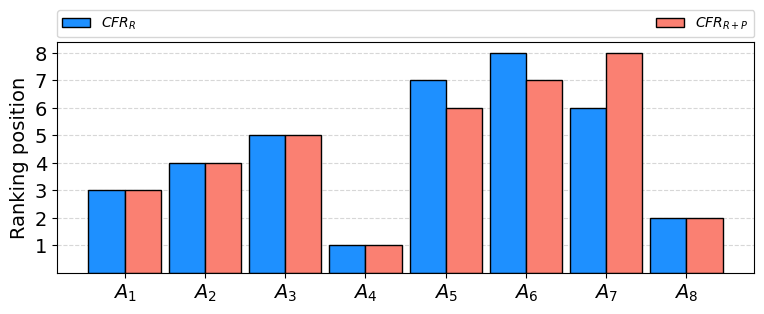

In [51]:
plt.rcParams['figure.figsize'] = (9, 3)
pymcdm.visuals.ranking_bar(np.array([experts_results['cfr_r'], experts_results['cfr_rp']]), labels=['$CFR_R$', '$CFR_{{R+P}}$'], colors=['dodgerblue', 'salmon'])
plt.ylabel('Ranking position', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('img/ranking_bar_cfr.pdf')
plt.show()

In [52]:
comparison_ranks_cfr_p = []
comparison_ranks_cfr_rp = []

for m_idx, method in enumerate(methods_dict.keys()):
    print(method)
    base_rankings = []
    base_prefs = []
    for f_idx, (ranks, label) in enumerate(zip(experts_results['results_ranks'], ['S', 'W', 'O', 'T'])):
        print(label)
        temp_ranks = []
        for e_idx, e_ranks in enumerate(ranks):
            print(e_ranks[0])
            temp_ranks.append(e_ranks[0])
            base_rankings.append(e_ranks[0])
            base_prefs.append(experts_results['results_prefs'][f_idx][e_idx][0])
        print('Range')
        print(np.min(temp_ranks, axis=0))
        print(np.max(temp_ranks, axis=0))

        print('')

    base_prefs = np.array(base_prefs)
    base_rankings = np.array(base_rankings)

    print('CFR')
    pref_cfr, pr_cfr = fr_compromise(base_rankings, base_prefs, m_types=[1 if m_idx != 1 else -1]*len(base_prefs))
    print(pref_cfr, pr_cfr)
    print('')

    comparison_ranks_cfr_p.append(pref_cfr)
    comparison_ranks_cfr_rp.append(pr_cfr)

comparison_ranks_cfr_p = np.array(comparison_ranks_cfr_p)
comparison_ranks_cfr_rp = np.array(comparison_ranks_cfr_rp)

MARCOS
S
[3. 4. 5. 6. 7. 8. 2. 1.]
[1. 5. 6. 3. 7. 8. 4. 2.]
[1. 5. 6. 2. 7. 8. 4. 3.]
[4. 3. 6. 1. 7. 8. 5. 2.]
[1. 5. 6. 2. 4. 8. 7. 3.]
Range
[1. 3. 5. 1. 4. 8. 2. 1.]
[4. 5. 6. 6. 7. 8. 7. 3.]

W
[4. 2. 5. 1. 6. 8. 7. 3.]
[3. 4. 5. 1. 6. 8. 7. 2.]
[2.5 4.  5.  1.  6.  8.  7.  2.5]
[4. 3. 6. 1. 5. 8. 7. 2.]
[2. 6. 4. 3. 7. 5. 8. 1.]
Range
[2. 2. 4. 1. 5. 5. 7. 1.]
[4. 6. 6. 3. 7. 8. 8. 3.]

O
[4. 2. 6. 1. 7. 8. 5. 3.]
[3.5 2.  5.  1.  6.  8.  7.  3.5]
[3.5 2.  5.  1.  6.  8.  7.  3.5]
[4. 3. 7. 1. 5. 6. 8. 2.]
[4. 3. 5. 1. 7. 6. 8. 2.]
Range
[3.5 2.  5.  1.  5.  6.  5.  2. ]
[4.  3.  7.  1.  7.  8.  8.  3.5]

T
[1. 4. 5. 3. 8. 7. 6. 2.]
[2. 4. 5. 1. 8. 6. 7. 3.]
[2.  4.  5.5 1.  5.5 8.  7.  3. ]
[5. 8. 3. 4. 2. 7. 6. 1.]
[2. 7. 3. 6. 8. 5. 4. 1.]
Range
[1. 4. 3. 1. 2. 5. 4. 1.]
[5.  8.  5.5 6.  8.  8.  7.  3. ]

CFR
[3. 4. 5. 1. 7. 8. 6. 2.] [3. 4. 5. 1. 6. 7. 8. 2.]

CODAS
S
[3. 4. 5. 6. 7. 8. 2. 1.]
[1. 5. 6. 3. 7. 8. 4. 2.]
[1. 5. 6. 2. 7. 8. 4. 3.]
[4. 3. 6. 1. 7. 8. 5. 2.]
[1. 

In [53]:
corr_rw_p = [[pymcdm.correlations.rw(r1, r2) for r2 in comparison_ranks_cfr_p]for r1 in comparison_ranks_cfr_p]
corr_rw_rp = [[pymcdm.correlations.rw(r1, r2) for r2 in comparison_ranks_cfr_rp]for r1 in comparison_ranks_cfr_rp]

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def correlation_heatmap(corr_matrix,
                        labels=None,
                        labels_rotation=45,
                        labeltop=False,
                        float_fmt='%0.2f',
                        cmap='Greens',
                        adapt_text_colors=None,
                        adapt_text_threshold=None,
                        colorbar=False,
                        cbar_label='',
                        show_axis=True,
                        show_grid=False,
                        grid_kwargs=dict(),
                        text_kwargs=dict(),
                        ax=None):
    """ Function for visualisation correlation matrix as a color heatmap.

        Parameters
        ----------
            corr_matrix : ndarray
                Square matrix of correlation values. For example could be generated with function pymcdm.correlation.correlation_matrix.

            labels : Iterable or None
                Labels for rankings (will be displayed as a xticklabels and yticklabels). Default is None.

            labels_rotation : float
                Angle for label rotation. In some cases labels on the X axis will be overlaps, so rotating them could help. Default is 45.

            labeltop : bool
                If True, put labels from X axis on top of the heatmap. Default is False

            float_fmt : str
                Format of the float values on the plot. Default is '%0.2f'

            cmap : str or Colormap
                Colormap for heatmap. Accepts any colormap which is valid matplotlib colormap. Default is 'Greens'.

            adapt_text_colors : tuple or None
                If None, all text will be in one color. In other case, two elements tuple should be provided. For example, passing tuple ('w', 'k') will be retulted in black text if value for this element is bigger or equal to adapt_text_threshold or 'w' if less. Default is None.

            adapt_text_threshold : float or None
                If adapt_text_colors is not None then this value is used selection of text' text. If None, then average value of corr_matrix is chosen. Default is None.

            colorbar : bool
                Add colorbar on the right side of the axis. Default is False.

            show_axis : bool
                If False, then axis (black square) around plot is disabled. Could be useful if you want to add grid to the heatmap. Default is True.

            show_grid : bool
                If True, then grid is added to the heatmap. Default is False.

            grid_kwargs : dict
                Keyword arguments to pass to the grid function.

            text_kwargs : dict
                Keyword arguments to pass to the text function (for matrix values).

            ax : Axes
                Axes object to draw on.

        Returns
        -------
            ax : Axes
                Axes object on which plot were drawn.

            cax : Axes
                Only if colorbar=True.
                Axes object on which colorbar were drawn.
    """
    corr_matrix = np.asarray(corr_matrix)

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = [f'$R_{{{i + 1}}}$' for i in range(corr_matrix.shape[0])]

    im = ax.imshow(corr_matrix, cmap=cmap)

    text_kwargs = dict(
        ha='center',
        va='center',
        color='k'
    ) | text_kwargs

    if adapt_text_colors is not None:
        if adapt_text_threshold is None:
            adapt_text_threshold = np.mean(corr_matrix)

        for i in range(len(labels)):
            for j in range(len(labels)):
                text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)
    else:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)

    if labeltop:
        ax.tick_params(top=labeltop, bottom=not labeltop,
                       labeltop=labeltop, labelbottom=not labeltop)

    if not show_axis:
        ax.spines[:].set_visible(False)

    if labels_rotation:
        plt.setp(ax.get_xticklabels(), rotation=labels_rotation,
                 ha='left' if labeltop else 'right', rotation_mode='anchor')

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    if show_grid:
        grid_kwargs = dict(
            color='w',
            linestyle='-',
            linewidth=3
        ) | grid_kwargs | dict(which='minor')

        ax.set_xticks(np.arange(corr_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(corr_matrix.shape[0]+1)-.5, minor=True)
        ax.grid(**grid_kwargs)
        ax.tick_params(which='minor', bottom=False, left=False)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        cbar.set_label(cbar_label, fontsize=12)
        return ax, cax

    return ax


C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\3500974597.py:97: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]


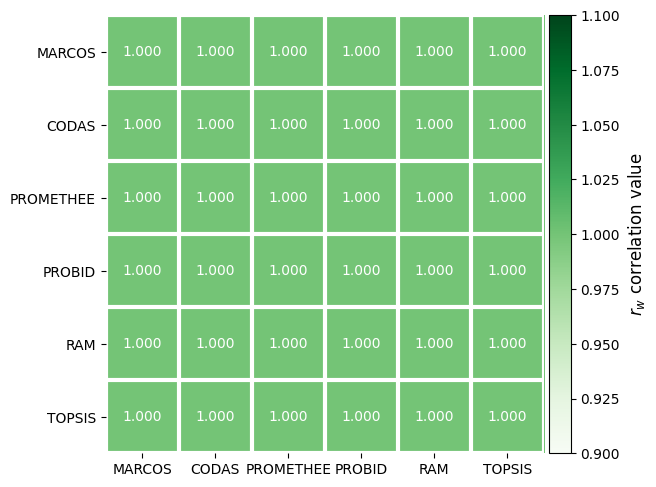

In [55]:
labels = list(methods_dict.keys())

plt.rcParams['figure.figsize'] = (6, 6)
correlation_heatmap(np.array(corr_rw_p), labels, labels_rotation=0, float_fmt='%0.3f', cmap='Greens', adapt_text_colors=['k', 'w'], colorbar=True, show_axis=False, show_grid=True, cbar_label='$r_w$ correlation value')
# plt.savefig('img/rw_corr_p.pdf')
plt.show()

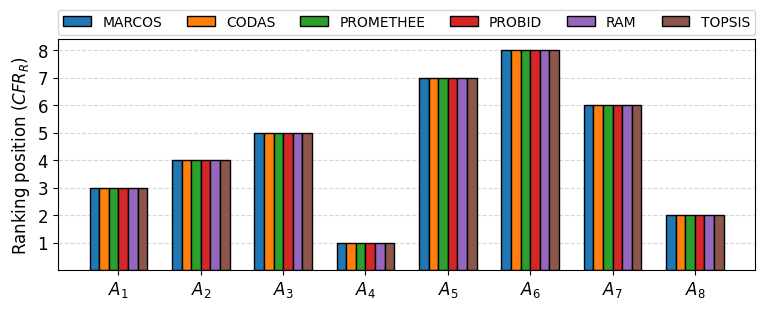

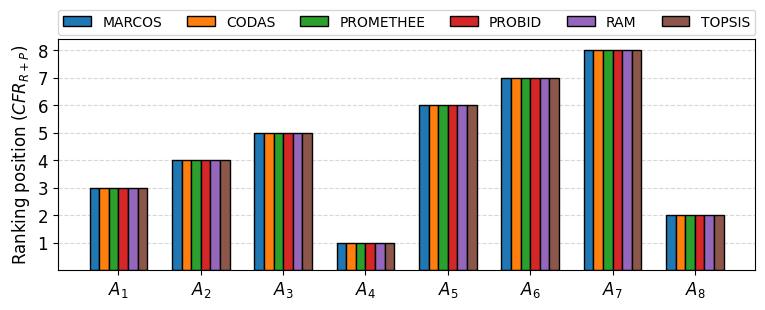

In [56]:
plt.rcParams['figure.figsize'] = (9, 3)
pymcdm.visuals.ranking_bar(comparison_ranks_cfr_p, labels, legend_ncol=len(labels))
plt.ylabel('Ranking position ($CFR_R$)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('img/ranking_bar_cfr_r.pdf')
plt.show()

pymcdm.visuals.ranking_bar(comparison_ranks_cfr_rp, labels, legend_ncol=len(labels))
plt.ylabel('Ranking position ($CFR_{{R+P}}$)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('img/ranking_bar_cfr_rp.pdf')
plt.show()

In [57]:
all_results = [
    experts_results,
    gpt_results,
    gpt_collectively_results,
    gemini_results,
    gemini_collectively_results,
    grok_results,
    grok_collectively_results,
    sonar_results,
    sonar_collectively_results,
    sonnet_results,
    sonnet_collectively_results
]

corr_weights = [[], [], [], []]

corr_cfr_r = []
corr_cfr_rp = []

l = ['s', 'w', 'o', 't']
results_labels = ['experts', 'gpt', 'gpt*', 'flash 2.5', 'flash 2.5*', 'grok', 'grok*', 'sonar', 'sonar*', 'sonnet', 'sonnet*']

for r_idx, r in enumerate(all_results):
    print(results_labels[r_idx])
    for idx, w_factor in enumerate(r['weights']):
        w = np.mean(w_factor, axis=0)
        std = np.std(w_factor, axis=0)

        for i, (ww, stdd) in enumerate(zip(w, std)):
            print(f'{l[idx]}{i+1}: {round(ww, 3)} +- {np.round(stdd, 3)}')
        print()

        corr_weights[idx].append(w)
        
    corr_cfr_r.append(r['cfr_r'])
    corr_cfr_rp.append(r['cfr_rp'])


experts
s1: 0.271 +- 0.033
s2: 0.159 +- 0.013
s3: 0.183 +- 0.009
s4: 0.126 +- 0.012
s5: 0.112 +- 0.013
s6: 0.148 +- 0.018

w1: 0.12 +- 0.01
w2: 0.171 +- 0.012
w3: 0.109 +- 0.012
w4: 0.21 +- 0.018
w5: 0.151 +- 0.014
w6: 0.239 +- 0.025

o1: 0.156 +- 0.017
o2: 0.126 +- 0.01
o3: 0.17 +- 0.011
o4: 0.106 +- 0.007
o5: 0.308 +- 0.036
o6: 0.135 +- 0.009

t1: 0.201 +- 0.015
t2: 0.164 +- 0.009
t3: 0.135 +- 0.011
t4: 0.218 +- 0.017
t5: 0.114 +- 0.013
t6: 0.169 +- 0.004

gpt
s1: 0.182 +- 0.037
s2: 0.168 +- 0.027
s3: 0.17 +- 0.05
s4: 0.233 +- 0.075
s5: 0.105 +- 0.007
s6: 0.143 +- 0.024

w1: 0.103 +- 0.013
w2: 0.174 +- 0.011
w3: 0.124 +- 0.007
w4: 0.278 +- 0.015
w5: 0.127 +- 0.017
w6: 0.193 +- 0.027

o1: 0.115 +- 0.01
o2: 0.201 +- 0.045
o3: 0.255 +- 0.042
o4: 0.097 +- 0.006
o5: 0.162 +- 0.038
o6: 0.17 +- 0.019

t1: 0.144 +- 0.014
t2: 0.219 +- 0.034
t3: 0.105 +- 0.014
t4: 0.219 +- 0.04
t5: 0.144 +- 0.019
t6: 0.168 +- 0.032

gpt*
s1: 0.166 +- 0.029
s2: 0.225 +- 0.059
s3: 0.129 +- 0.013
s4: 0.205 +- 0.0

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def correlation_heatmap(corr_matrix,
                        labels=None,
                        labels_rotation=90,
                        labeltop=False,
                        float_fmt='%0.2f',
                        cmap='Greens',
                        adapt_text_colors=None,
                        adapt_text_threshold=None,
                        colorbar=False,
                        show_axis=True,
                        show_grid=False,
                        grid_kwargs=dict(),
                        text_kwargs=dict(),
                        ax=None):
    """ Function for visualisation correlation matrix as a color heatmap.

        Parameters
        ----------
            corr_matrix : ndarray
                Square matrix of correlation values. For example could be generated with function pymcdm.correlation.correlation_matrix.

            labels : Iterable or None
                Labels for rankings (will be displayed as a xticklabels and yticklabels). Default is None.

            labels_rotation : float
                Angle for label rotation. In some cases labels on the X axis will be overlaps, so rotating them could help. Default is 45.

            labeltop : bool
                If True, put labels from X axis on top of the heatmap. Default is False

            float_fmt : str
                Format of the float values on the plot. Default is '%0.2f'

            cmap : str or Colormap
                Colormap for heatmap. Accepts any colormap which is valid matplotlib colormap. Default is 'Greens'.

            adapt_text_colors : tuple or None
                If None, all text will be in one color. In other case, two elements tuple should be provided. For example, passing tuple ('w', 'k') will be retulted in black text if value for this element is bigger or equal to adapt_text_threshold or 'w' if less. Default is None.

            adapt_text_threshold : float or None
                If adapt_text_colors is not None then this value is used selection of text' text. If None, then average value of corr_matrix is chosen. Default is None.

            colorbar : bool
                Add colorbar on the right side of the axis. Default is False.

            show_axis : bool
                If False, then axis (black square) around plot is disabled. Could be useful if you want to add grid to the heatmap. Default is True.

            show_grid : bool
                If True, then grid is added to the heatmap. Default is False.

            grid_kwargs : dict
                Keyword arguments to pass to the grid function.

            text_kwargs : dict
                Keyword arguments to pass to the text function (for matrix values).

            ax : Axes
                Axes object to draw on.

        Returns
        -------
            ax : Axes
                Axes object on which plot were drawn.

            cax : Axes
                Only if colorbar=True.
                Axes object on which colorbar were drawn.
    """
    corr_matrix = np.asarray(corr_matrix)

    if ax is None:
        ax = plt.gca()

    if labels is None:
        labels = [f'$R_{{{i + 1}}}$' for i in range(corr_matrix.shape[0])]

    im = ax.imshow(corr_matrix, cmap=cmap)

    text_kwargs = dict(
        ha='center',
        va='center',
        color='k'
    ) | text_kwargs

    if adapt_text_colors is not None:
        if adapt_text_threshold is None:
            adapt_text_threshold = np.mean(corr_matrix)

        for i in range(len(labels)):
            for j in range(len(labels)):
                text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)
    else:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, float_fmt % corr_matrix[i, j], **text_kwargs)

    if labeltop:
        ax.tick_params(top=labeltop, bottom=not labeltop,
                       labeltop=labeltop, labelbottom=not labeltop)

    if not show_axis:
        ax.spines[:].set_visible(False)

    # if labels_rotation:
    #     plt.setp(ax.get_xticklabels(), rotation=labels_rotation,
    #              ha='left' if labeltop else 'right', rotation_mode='anchor')

    ax.set_xticks(np.arange(len(labels)), labels=labels, rotation=90)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    if show_grid:
        grid_kwargs = dict(
            color='w',
            linestyle='-',
            linewidth=3
        ) | grid_kwargs | dict(which='minor')

        ax.set_xticks(np.arange(corr_matrix.shape[1]+1)-.5, minor=True)
        ax.set_yticks(np.arange(corr_matrix.shape[0]+1)-.5, minor=True)
        ax.grid(**grid_kwargs)
        ax.tick_params(which='minor', bottom=False, left=False)

    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cbar = plt.colorbar(im, cax=cax)
        return ax, cax

    return ax


In [73]:
labels = [
    'Experts',
    'GPT 5.1',
    'GPT 5.1$^*$',
    'Flash 2.5',
    'Flash 2.5$^*$',
    'Grok 4.1',
    'Grok 4.1$^*$',
    'Sonar',
    'Sonar$^*$',
    'Sonnet 4.5',
    'Sonnet 4.5$^*$'
]

C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, 

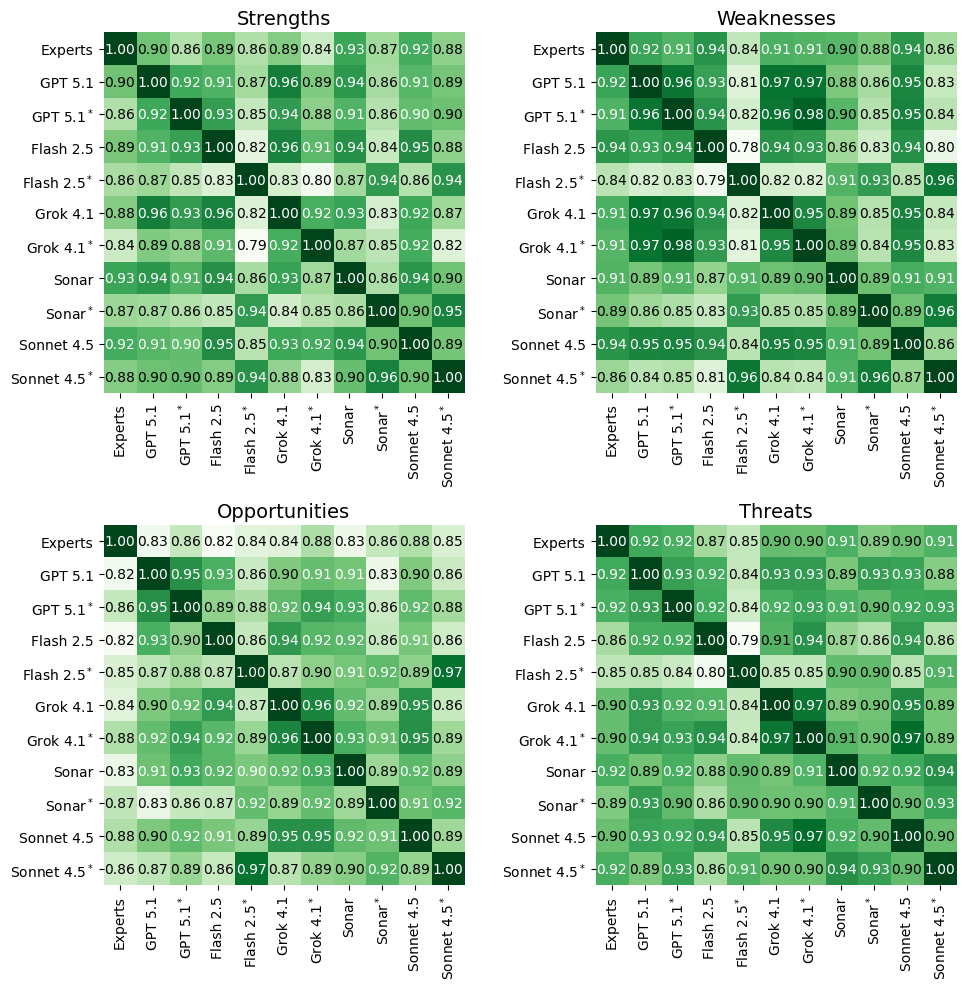

In [80]:
plt.rcParams['figure.figsize'] = (10, 10)
SWOT_LABELS_FULL = ['Strengths', 'Weaknesses', 'Opportunities', 'Threats']

fig, axes = plt.subplots(2, 2)

for ax, w_factor, label in zip(axes.flatten(), corr_weights, SWOT_LABELS_FULL):
    wsc_corr = pymcdm.helpers.correlation_matrix(
        np.array(w_factor),
        pymcdm.correlations.wsc
    )
    
    correlation_heatmap(
        wsc_corr,
        labels=labels,
        labels_rotation=90,
        ax=ax,
        adapt_text_colors=['k','w'],
        show_axis=False,
    )
    
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.savefig('img/corr_weights_all.pdf')
plt.show()
plt.close()


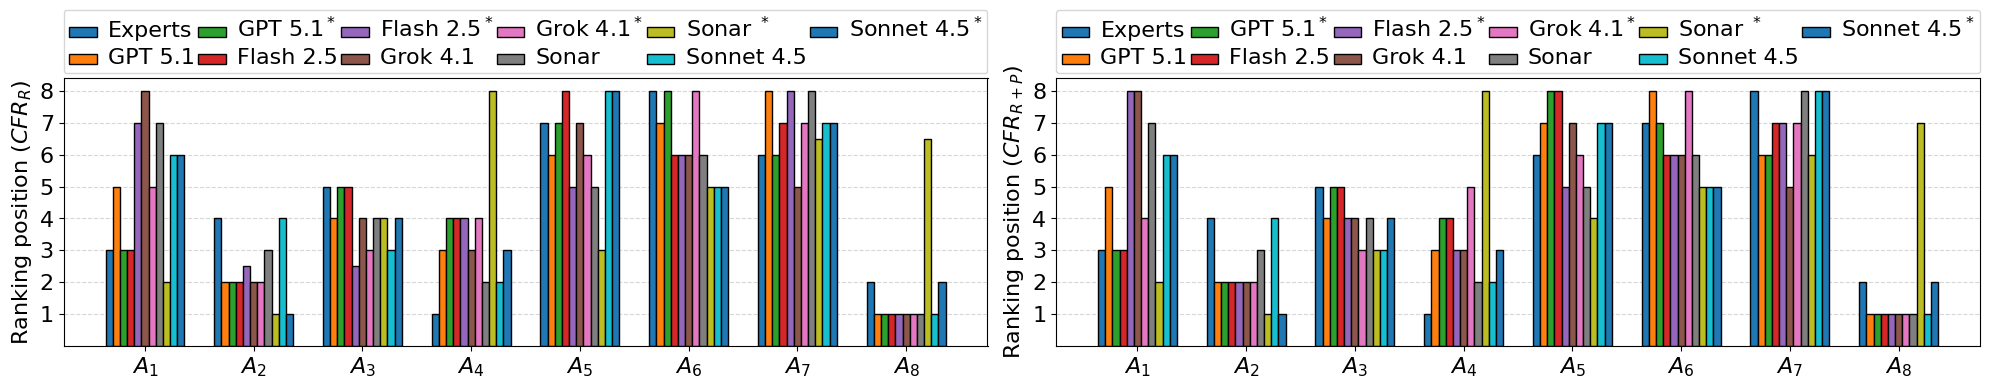

In [68]:
plt.rcParams['figure.figsize'] = (20, 4)
CFR_LABELS = ['$CFR_R$', '$CFR_{{R+P}}$']

fig, axes = plt.subplots(1, 2)

# First plot
pymcdm.visuals.ranking_bar(
    corr_cfr_r,
    labels=labels,
    spacing=0.05,
    legend_ncol=6,
    ax=axes[0]
)
axes[0].set_ylabel(r'Ranking position ($CFR_R$)', fontsize=16)
axes[0].tick_params(axis='both', labelsize=16)

leg = axes[0].get_legend()
if leg:
    for t in leg.get_texts():
        t.set_fontsize(16)

# Second plot
pymcdm.visuals.ranking_bar(
    corr_cfr_rp,
    labels=labels,
    spacing=0.05,
    legend_ncol=6,
    ax=axes[1]
)
axes[1].set_ylabel(r'Ranking position ($CFR_{R+P}$)', fontsize=16)
axes[1].tick_params(axis='both', labelsize=16)

leg = axes[1].get_legend()
if leg:
    for t in leg.get_texts():
        t.set_fontsize(16)

plt.tight_layout()
plt.savefig('img/ranking_bar_cfr_all.pdf', bbox_inches='tight')
plt.show()
plt.close()


In [69]:
corr_cfr_r_rw = pymcdm.helpers.correlation_matrix(np.array(corr_cfr_r), pymcdm.correlations.rw)
corr_cfr_rp_rw = pymcdm.helpers.correlation_matrix(np.array(corr_cfr_rp), pymcdm.correlations.rw)

C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]
C:\Users\kubaw\AppData\Local\Temp\ipykernel_54344\1078591006.py:96: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  text_kwargs['color'] = adapt_text_colors[corr_matrix[i, j] >= adapt_text_threshold]


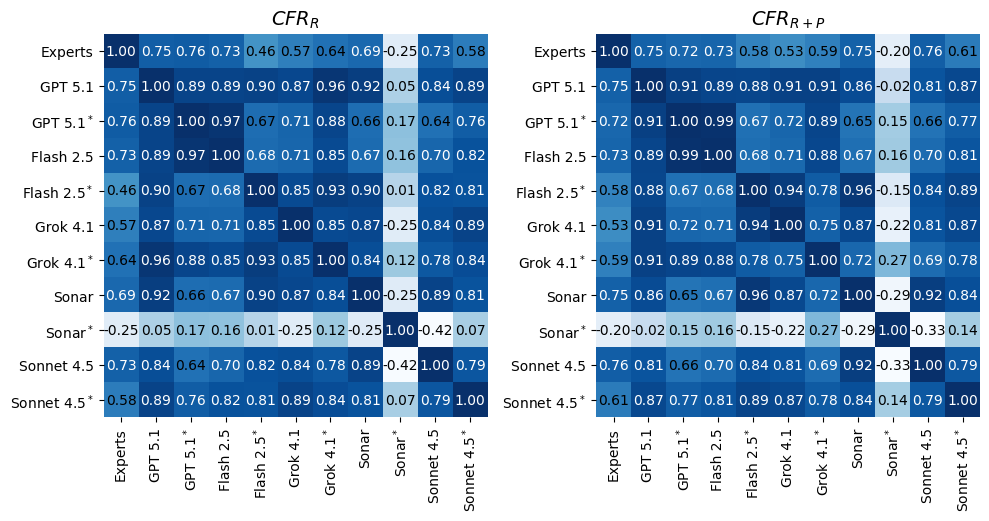

In [81]:
plt.rcParams['figure.figsize'] = (10, 10)
CFR_LABELS = ['$CFR_R$', '$CFR_{{R+P}}$']

fig, axes = plt.subplots(1, 2)

for ax, cfr_corr, label in zip(axes.flatten(), [corr_cfr_r_rw, corr_cfr_rp_rw], CFR_LABELS):
    
    correlation_heatmap(
        cfr_corr,
        cmap='Blues',
        labels=labels,
        labels_rotation=90,
        ax=ax,
        adapt_text_colors=['k','w'],
        show_axis=False,
        # show_grid=True
    )
    
    ax.set_title(label, fontsize=14)

plt.tight_layout()
plt.savefig('img/corr_cfr_all.pdf')
plt.show()
plt.close()


# Risk assessment

- C1 - powtarzalność i stabilność (czy odpowiedzi w różnych formacie)
- C2 - przydatność struktury danych (czy struktura odpowiedzi w tym samym formacie czyli czy wymaga transpozycji)
- C3 - czy podane uzasadnienie
- C4 - czy podane referencje lub linki
- C5 - propozycje dalszych kroków
- C6 - korelacje z ekspertami

In [71]:
alpha = 0.88    # Sensitivity to gains/losses
beta = 0.88
lambda_ = 2.25  # Loss aversion parameter

def prospect_theory_value_matrix(value, neutral_value, criteria_type, alpha=alpha, beta=beta, lambda_=lambda_):
    diff = value - neutral_value

    if criteria_type == 1:
        if diff > 0:    
            return (value - neutral_value)**alpha
        return -lambda_ * (-(value - neutral_value)) ** beta
    
    if diff < 0:    
        return (-(value - neutral_value))**alpha
    return -lambda_ * ((value - neutral_value)) ** beta

        

In [72]:
risk_matrix = np.array([
    [67, 50, 0, 0, 100, 0.75], # gpt
    [83, 67, 17, 0, 33, 0.73], # gemini
    [100, 83, 0, 0, 0, 0.57], # grok
    [33, 83, 0, 33, 33, 0.69], # sonar
    [0, 83, 67, 0, 33, 0.73], # sonnet
])

neutral_values = np.array([80, 60, 75, 80, 30, 0.8])
bounds = np.array([
    [0, 100],
    [0, 100],
    [0, 100],
    [0, 100],
    [0, 100],
    [0, 1],
])
criteria_types = np.array([1, 1, 1, 1, 1, 1])

result_matrix = np.zeros_like(risk_matrix).astype(float)
result_matrix_neg = np.zeros_like(risk_matrix).astype(float)

for i in range(risk_matrix.shape[1]):    
    x = np.linspace(bounds[i][0], bounds[i][1], 1000)
    for k in range(risk_matrix.shape[0]):
        result_matrix_neg[k, i] = prospect_theory_value_matrix(risk_matrix[k, i], neutral_values[i], criteria_types[i])
        result_matrix[k, i] = np.abs( prospect_theory_value_matrix(risk_matrix[k, i], neutral_values[i], criteria_types[i]))


print(np.round(result_matrix_neg, 3))
print(np.sum(result_matrix_neg, axis=1))
print(pymcdm.helpers.rrankdata(np.sum(result_matrix_neg, axis=1)))


[[ -21.501  -17.068 -100.516 -106.39    42.042   -0.161]
 [   2.629    5.542  -80.168 -106.39     2.629   -0.217]
 [  13.961   15.788 -100.516 -106.39   -44.88    -0.617]
 [ -66.624   15.788 -100.516  -66.624    2.629   -0.323]
 [-106.39    15.788  -14.025 -106.39     2.629   -0.217]]
[-203.59408952 -175.97340102 -222.65500639 -215.66898807 -208.60488713]
[2. 1. 5. 4. 3.]
